stock market data 

Welcome to this notebook on ARMA (AutoRegressive Moving Average) and ARIMA (AutoRegressive Integrated Moving Average) modeling. These are powerful statistical tools used for time series forecasting, which involves predicting future values based on historical data. This notebook provides a comprehensive guide on implementing ARMA and ARIMA models in Python, from data preprocessing to model evaluation.

We will cover the following key topics:

Understanding Time Series Data: An overview of time series data and its significance.

Data Preprocessing: Preparing time series data for ARIMA modeling, including handling missing values and detecting trends and seasonality.

ARMA and ARIMA Model Building: Explanation of the components (p, d, q) and selecting optimal parameters.

Model Training and Forecasting: Training ARMA and ARIMA models on historical data and generating forecasts.

Model Evaluation: Metrics and methods to evaluate model performance.

Applications and Limitations: Real-world uses of ARMA and ARIMA models and their limitations.

This will give a clear understanding of ARMA and ARIMA modeling and appliction to forecasting projects.

We will use the Yahoo Finance API to pull stock data, which makes an excellent dataset for exploring ARMA and ARIMA models. Specifically, we'll analyze Google's stock data as it is a time series (data with a time component, where time is crucial).





In [2]:
#CLI command to install the dependencies
#!pip install scikit-learn statsmodels pandas numpy matplotlib yfinance seaborn pandas-ta --quiet
!pip install pandas-ta --quiet


In [3]:
#Importing Libaries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_ta as ta
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] =  (22,5)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


In [8]:
#Loading the data into a tabular format / pandas dataframe
symbol = 'GOOGL'
#df = yf.Ticker(symbol).history(period='max').reset_index()
df = yf.Ticker(symbol).history(start = "2020-01-01", end = "2023-12-31").reset_index()


#getting only the date and not the time
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

df.head()



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-02,67.176978,68.186813,67.081324,68.186813,27278000,0.0,0.0
1,2020-01-03,67.156555,68.439404,67.122674,67.830109,23408000,0.0,0.0
2,2020-01-06,67.337388,69.663459,67.306008,69.638054,46768000,0.0,0.0
3,2020-01-07,69.770083,69.921535,69.326691,69.503548,34330000,0.0,0.0
4,2020-01-08,69.489089,70.337515,69.379988,69.998245,35314000,0.0,0.0


In [9]:
columns = yf.Ticker(symbol).income_stmt.reset_index().T.iloc[0].values.tolist()

columns

['Tax Effect Of Unusual Items',
 'Tax Rate For Calcs',
 'Normalized EBITDA',
 'Total Unusual Items',
 'Total Unusual Items Excluding Goodwill',
 'Net Income From Continuing Operation Net Minority Interest',
 'Reconciled Depreciation',
 'Reconciled Cost Of Revenue',
 'EBITDA',
 'EBIT',
 'Net Interest Income',
 'Interest Expense',
 'Interest Income',
 'Normalized Income',
 'Net Income From Continuing And Discontinued Operation',
 'Total Expenses',
 'Total Operating Income As Reported',
 'Diluted Average Shares',
 'Basic Average Shares',
 'Diluted EPS',
 'Basic EPS',
 'Diluted NI Availto Com Stockholders',
 'Net Income Common Stockholders',
 'Net Income',
 'Net Income Including Noncontrolling Interests',
 'Net Income Continuous Operations',
 'Tax Provision',
 'Pretax Income',
 'Other Income Expense',
 'Other Non Operating Income Expenses',
 'Special Income Charges',
 'Earnings From Equity Interest',
 'Gain On Sale Of Security',
 'Net Non Operating Interest Income Expense',
 'Interest Expe

In [6]:
inc_stmt = yf.Ticker(symbol).income_stmt.reset_index().T[1:]
inc_stmt.columns = columns
inc_stmt = inc_stmt.reset_index().rename(columns={'index':'Date'}).sort_values(by='Date')
inc_stmt.head()


,Date,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,...,Operating Expense,Research And Development,Selling General And Administration,Selling And Marketing Expense,General And Administrative Expense,Other Gand A,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue
3,2020-12-31,970572126.783412,0.162493,55941000000.0,5973000000.0,5973000000.0,40269000000.0,13697000000.0,84732000000.0,61914000000.0,...,56571000000.0,27573000000.0,28998000000.0,17946000000.0,11052000000.0,11052000000.0,97795000000.0,84732000000.0,182527000000.0,182527000000.0
2,2021-12-31,1948860000.0,0.162,91491000000.0,12030000000.0,12030000000.0,76033000000.0,12441000000.0,110939000000.0,103521000000.0,...,67984000000.0,31562000000.0,36422000000.0,22912000000.0,13510000000.0,13510000000.0,146698000000.0,110939000000.0,257637000000.0,257637000000.0
1,2022-12-31,-981507000.0,0.159,91333000000.0,-6173000000.0,-6173000000.0,59972000000.0,13475000000.0,126203000000.0,85160000000.0,...,81791000000.0,39500000000.0,42291000000.0,26567000000.0,15724000000.0,15724000000.0,156633000000.0,126203000000.0,282836000000.0,282836000000.0
0,2023-12-31,-286479000.0,0.139,100032000000.0,-2061000000.0,-2061000000.0,73795000000.0,11946000000.0,133332000000.0,97971000000.0,...,89769000000.0,45427000000.0,44342000000.0,27917000000.0,16425000000.0,16425000000.0,174062000000.0,133332000000.0,307394000000.0,307394000000.0


In [7]:
#top 5 rows
merged = pd.merge_asof(df, inc_stmt, on='Date', direction='nearest').fillna(0)
merged.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tax Effect Of Unusual Items,Tax Rate For Calcs,...,Operating Expense,Research And Development,Selling General And Administration,Selling And Marketing Expense,General And Administrative Expense,Other Gand A,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue
0,2020-01-02,67.176978,68.186813,67.081324,68.186813,27278000,0.0,0.0,9.705721e+08,0.162493,...,5.657100e+10,2.757300e+10,2.899800e+10,1.794600e+10,1.105200e+10,1.105200e+10,9.779500e+10,8.473200e+10,1.825270e+11,1.825270e+11
1,2020-01-03,67.156555,68.439404,67.122674,67.830109,23408000,0.0,0.0,9.705721e+08,0.162493,...,5.657100e+10,2.757300e+10,2.899800e+10,1.794600e+10,1.105200e+10,1.105200e+10,9.779500e+10,8.473200e+10,1.825270e+11,1.825270e+11
2,2020-01-06,67.337388,69.663459,67.306008,69.638054,46768000,0.0,0.0,9.705721e+08,0.162493,...,5.657100e+10,2.757300e+10,2.899800e+10,1.794600e+10,1.105200e+10,1.105200e+10,9.779500e+10,8.473200e+10,1.825270e+11,1.825270e+11
3,2020-01-07,69.770083,69.921535,69.326691,69.503548,34330000,0.0,0.0,9.705721e+08,0.162493,...,5.657100e+10,2.757300e+10,2.899800e+10,1.794600e+10,1.105200e+10,1.105200e+10,9.779500e+10,8.473200e+10,1.825270e+11,1.825270e+11
4,2020-01-08,69.489089,70.337515,69.379988,69.998245,35314000,0.0,0.0,9.705721e+08,0.162493,...,5.657100e+10,2.757300e+10,2.899800e+10,1.794600e+10,1.105200e+10,1.105200e+10,9.779500e+10,8.473200e+10,1.825270e+11,1.825270e+11


In [69]:
import os
localdatapath = os.getcwd()
print(localdatapath)


c:\Jalpa\Data Science UOT\Case Studies\JPY_ARIMA


In [73]:
# export df, inc_stmt and merged data to csv 

df.to_csv('googledata.csv',index=False)  # save the file in to csv format
inc_stmt.to_csv('income_stmt.csv',index=False)  # save the file in to csv format
merged.to_csv('merged.csv',index=False)  # save the file in to csv format


In [ ]:
# Specify the local folder and file name
output_path = r'c:\Jalpa\Data Science UOT\Case studies\JPY_ARIMA'
#output_path = r'c:\Users\JalpaZenisha\DSI\DSI_Team_Project_Bank_Marketing\experiments\data\processed\

df.to_csv(output_path,index=False)

print(f"File saved to {output_path}")


In [10]:
#various datatypes of the data
df.dtypes


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

In [11]:
#some common statistical info about the data
df.describe().T


,count,mean,min,25%,50%,75%,max,std
Date,1006,2021-12-30 11:57:08.230616320,2020-01-02 00:00:00,2020-12-30 06:00:00,2021-12-29 12:00:00,2022-12-28 18:00:00,2023-12-29 00:00:00,NaN
Open,1006.0,107.412853,52.62772,87.784272,109.392196,130.280956,150.703685,25.077372
High,1006.0,108.694248,53.152817,88.535676,111.033993,131.60505,150.999107,25.183972
Low,1006.0,106.210359,50.261298,86.634819,107.580015,128.524096,148.361183,24.893617
Close,1006.0,107.48062,52.516125,87.710535,109.491585,129.779526,149.297287,25.02414
Volume,1006.0,34499134.294235,9312000.0,25026850.0,30718000.0,39339000.0,123200000.0,15014268.524887
Dividends,1006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stock Splits,1006.0,0.019881,0.0,0.0,0.0,0.0,20.0,0.630567


In [12]:
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')


The data has 1006 rows and 8 columns


Lets look at the movement of Various figures (Open, High, Low, Close) over the months



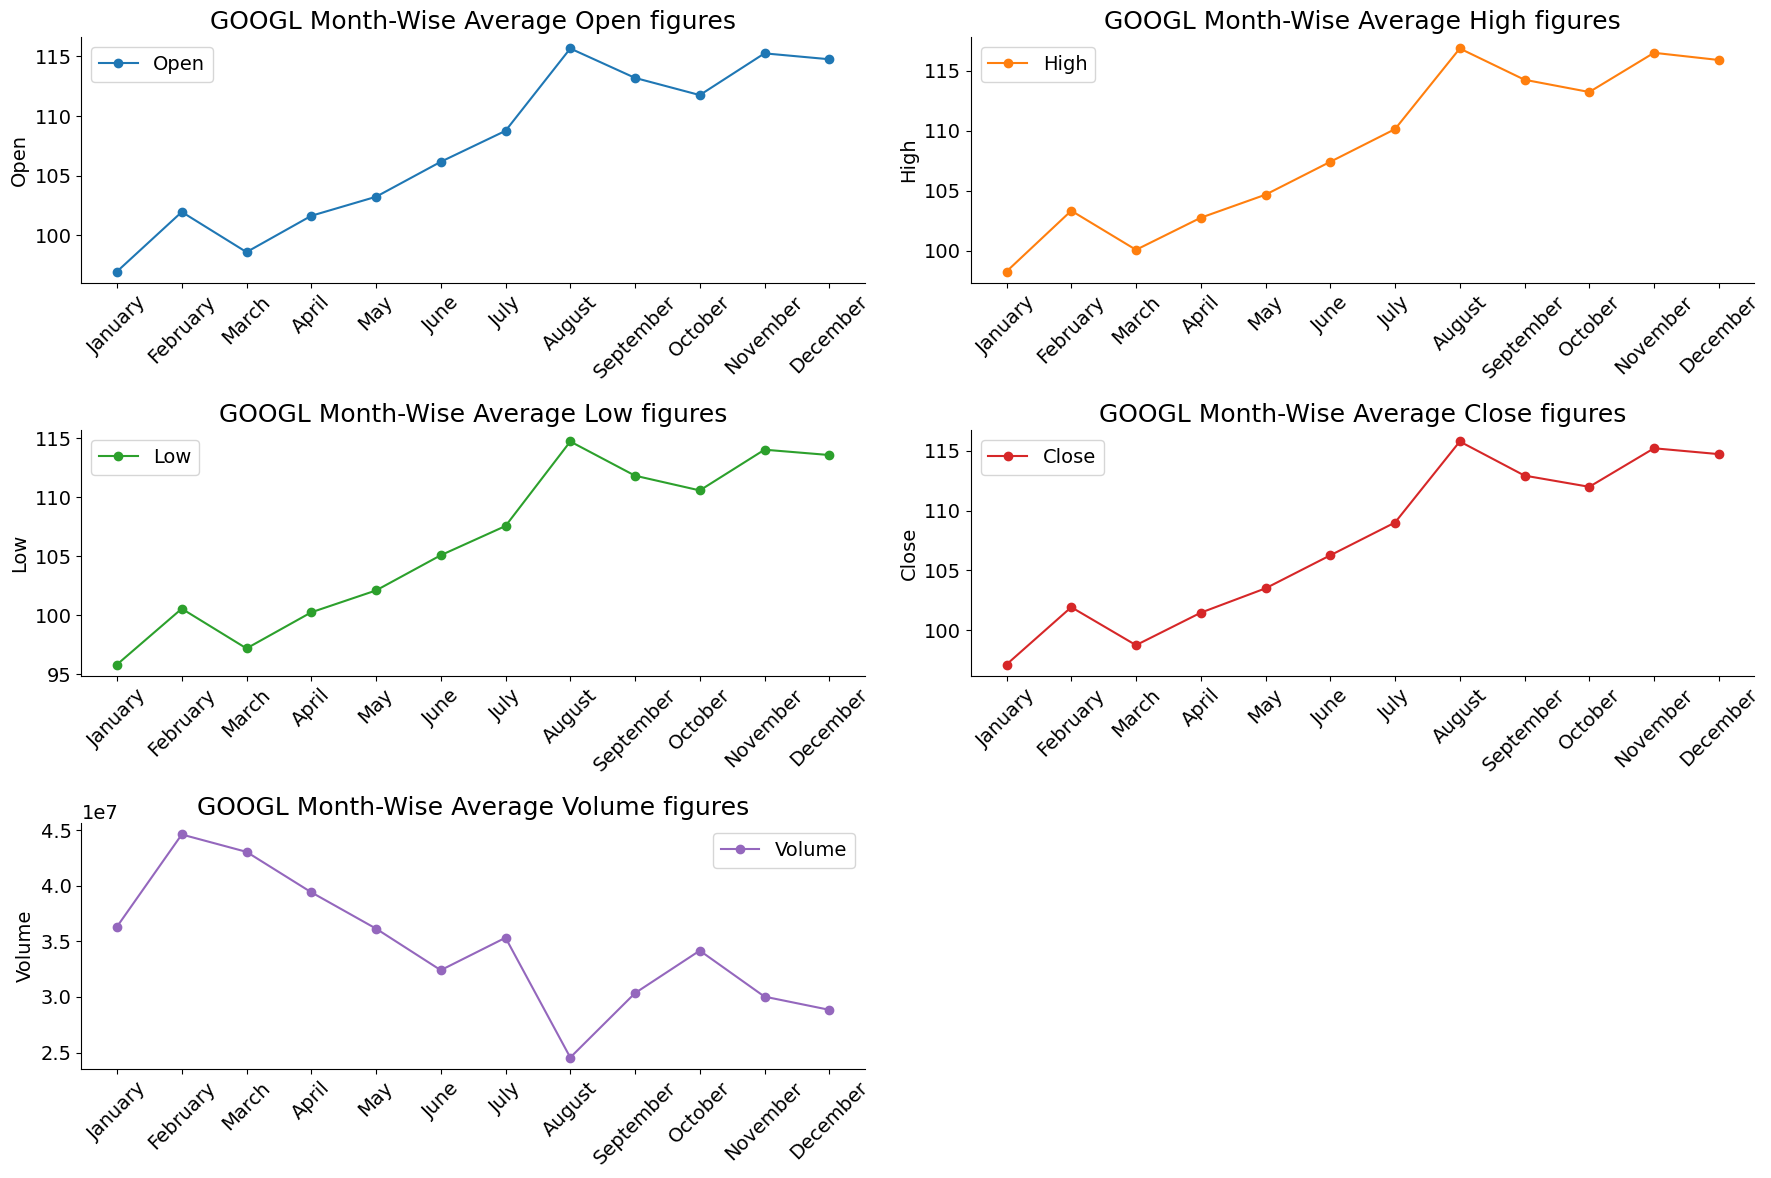

In [13]:
colors = plt.rcParams["axes.prop_cycle"]()
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot df

#Set the figure size of the plot
fig = plt.figure(figsize=(18,12))

n = len(df.groupby(df['Date'].dt.month_name(), sort=False).mean().columns[1:-2])

#Loop through the each column in the dataframe to generate a subplot
for i in range(1,n+1):
    color = next(colors)["color"]
    #Generate a subplot with the given dimensions
    plt.subplot(a, b, c)
    #Plot the data in a line graph, with different colors for each line
    plt.plot(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i], color= color, marker='o')
    #Remove the top and right borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #Rotate the x-tick labels by 45 degrees
    plt.xticks(rotation=45)
    #Set the title, x-axis label, y-axis label, and legend
    plt.title(f"{symbol} Month-Wise Average {df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name} figures", fontsize=18)
    plt.xlabel('')
    plt.ylabel(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name)
    plt.legend([df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name])
    #Increment the subplot df
    c = c + 1

#Adjust the layout of the plot
plt.tight_layout()
#Show the plot
plt.show()


INSIGHTS

Open, High, Low and close figures reach the maximum values around August and around November month.
Volume Avge Figures reach the max figures around February.
Let us also take a look at the date wise close price of the stock



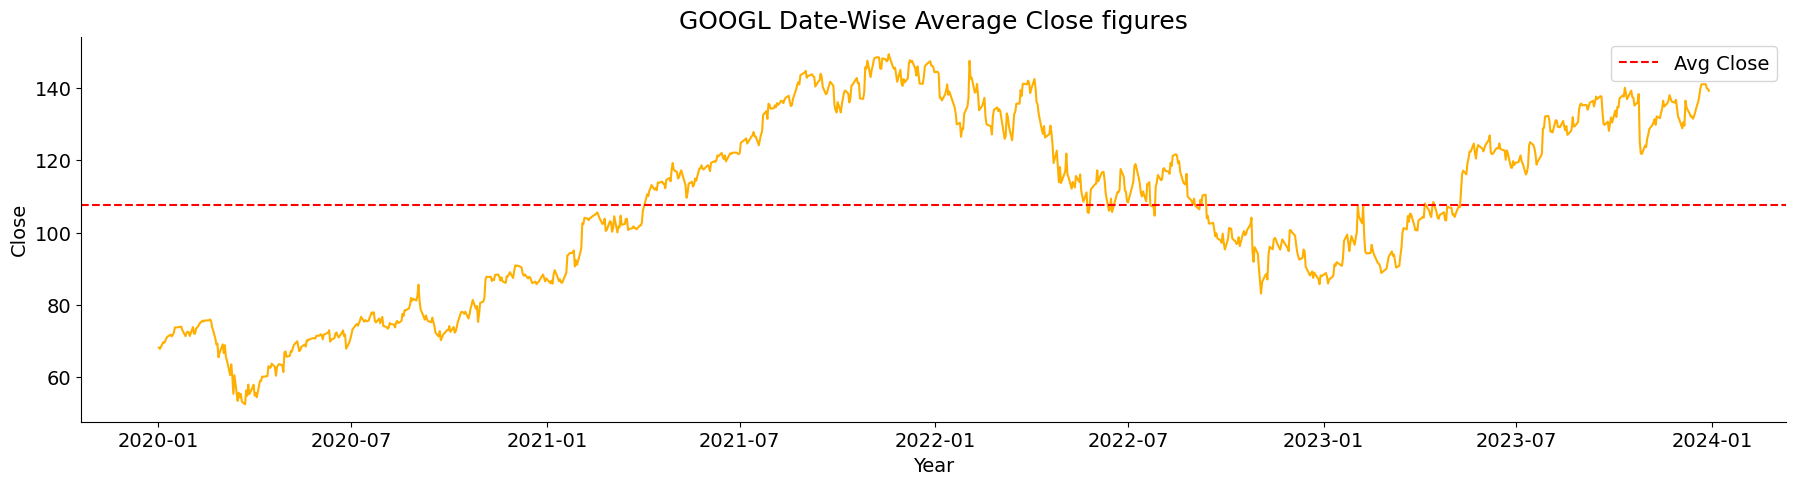

In [14]:
plt.plot(df.groupby(df['Date'], sort=False).mean().Close, color= '#FFAF00')
mean_close = round(df.groupby(df['Date']).mean()['Close'].mean(),2)
plt.axhline(mean_close, color='red', linestyle='--', label='Avg Close')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.title(f"{symbol} Date-Wise Average Close figures", fontsize=18)
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()


INSIGHTS

There is an upward trend in the price of stock which is definitely a good sign for the company and it's shareholders.

Let's now plot a box plot of all the 4 columns that is Open, High, Low and Close.



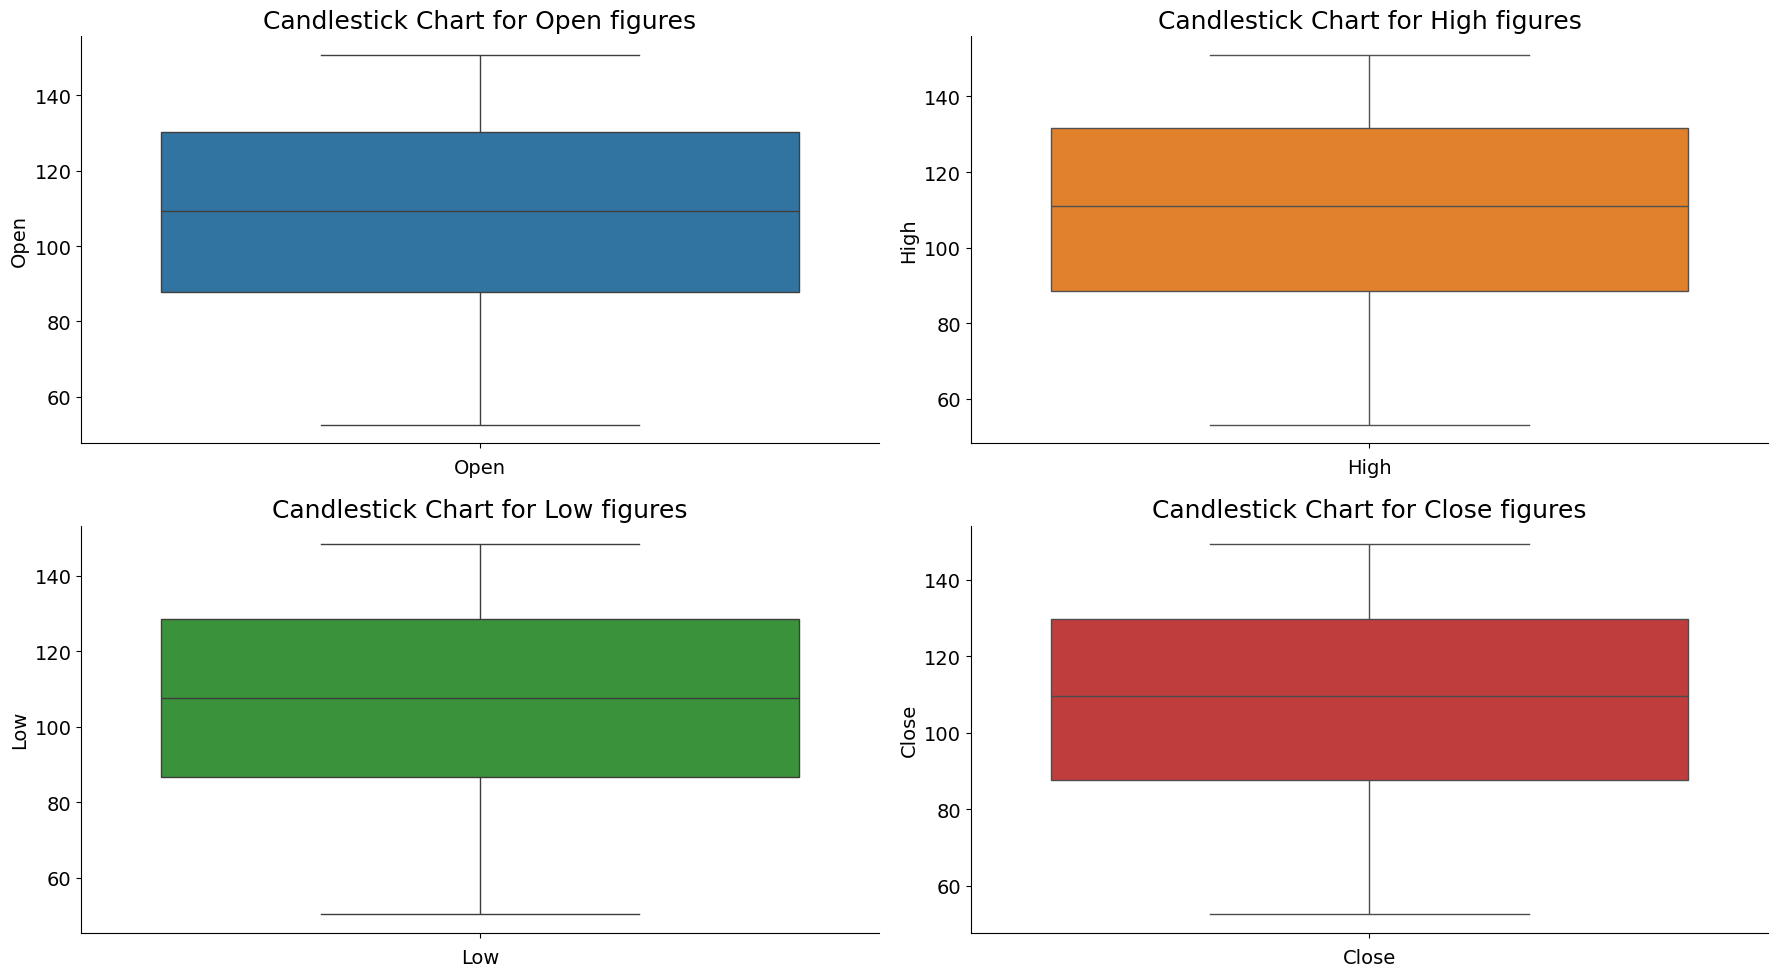

In [15]:
# This code plots boxplots of various columns in a dataframe, data_hist.

colors = plt.rcParams["axes.prop_cycle"]()

# The number of rows, columns, and the subplot counter are initialized.
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

# A figure is initialized
fig = plt.figure(figsize=(18,10))

length = range(1,len(df.columns[:-3]))

#loop is used to iterate over the columns of dataframe.
for i in length:
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    #For each column, a boxplot is plotted and labels and titles are set accordingly.
    sns.boxplot(df[df.columns[i]], color= color )
    # The spines of each plot are made invisible and the figure is adjusted and shown.
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #X Axis label is added
    plt.xlabel(df.columns[i])
    #title to the plot is added
    plt.title(f'Candlestick Chart for {df.columns[i]} figures', fontsize=18)
    c = c + 1

#Layout is tightended up
plt.tight_layout()

#plot is displayed
plt.show()


Predictions Using Analytical Techniques¶
Common Indicators for Stock Price Prediction
The commonly used Technical Indicators for Stock Price Predictions are below:-

1. MACD (Moving Average Convergence Divergence)
A trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. It’s often used for identifying buy/sell signals based on crossovers.
2. EMA (Exponential Moving Average)
A weighted moving average that gives more importance to recent data points. It is more sensitive to price changes than a Simple Moving Average (SMA) and is widely used to smooth out price data and detect trends.
3. SMA (Simple Moving Average)
A basic moving average that calculates the average price over a specific period. Often used in combination with the EMA or for crossover strategies.
4. ADX (Average Directional Index)
Measures the strength of a trend, often used alongside DI+ and DI- lines to determine whether a trend is strong or weak.
5. ATR (Average True Range)
A volatility indicator that measures market volatility by decomposing the entire range of an asset price for that period. It’s often used to set stop-loss levels.
6. Stochastic Oscillator (STOCH)
A momentum indicator that compares a stock’s closing price to its price range over a specific period. It’s commonly used to identify overbought or oversold conditions.
7. OBV (On-Balance Volume)
Measures volume flow to predict price movements. It accumulates the volume based on whether a security closes higher or lower than the previous period.
8. MFI (Money Flow Index)
A momentum indicator that uses price and volume data to identify overbought or oversold conditions, similar to RSI but with volume as a factor.
9. ROC (Rate of Change)
A momentum oscillator that measures the percentage change in price between the current price and a price from a certain number of periods ago.
10. VWAP (Volume Weighted Average Price)
The average price a security has traded at throughout the day, based on both volume and price. It’s often used as a trading benchmark.
11. Supertrend
A trend-following indicator that shows whether the price is in an uptrend or downtrend based on price volatility.
12. Keltner Channels (KC)
A volatility-based envelope indicator similar to Bollinger Bands, except that it uses the ATR to set the channel distance from a central moving average.
These indicators are widely used by traders for developing strategies, detecting trends, momentum, volatility, and potential buy/sell signals.

Crossover Approach: Golden Cross & Death Cross
1. Golden Cross (Bullish Signal):
What it is: Occurs when a short-term moving average (e.g., 7-day or 50-day) crosses above a long-term moving average (e.g., 14-day or 200-day).
What it indicates: Signals a shift from bearish to bullish momentum, suggesting an upward trend.
When to Buy: Considered a buy signal, as traders expect further price increases.

Example: When the 7-day EMA crosses above the 14-day EMA, it indicates recent prices are rising faster than the past, suggesting a positive trend.

2. Death Cross (Bearish Signal):
What it is: Happens when a short-term moving average crosses below a long-term moving average.
What it indicates: Signals a shift to bearish momentum, suggesting a downward trend.
When to Sell: Considered a sell signal, as traders expect further price drops.

Example: When the 7-day EMA crosses below the 14-day EMA, it indicates recent prices are falling faster than the past, signaling potential declines.

Using Crossovers to Predict Price Movements
Golden Cross: When a short-term MA crosses above a long-term MA, it indicates a potential bullish market and price increase.
Death Cross: When a short-term MA crosses below a long-term MA, it signals a bearish market, and prices might continue to drop.
Strategy:

Monitor the 7-day and 14-day/21-day EWMA.
Look for crossover events (Golden Cross or Death Cross) to predict price movements.
Combine with other indicators like RSI and MACD for more accurate signals.


In [16]:
spans = [7,14,21]
for span in spans:
    df[f"EWMA_{span}D"] = df['Close'].ewm(span, adjust=False).mean()
    df[f'EWMA_{span}D_diff'] = df['Close'] - df[f"EWMA_{span}D"]

df['Close_Pct_Change'] = df['Close'].pct_change()*100
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

span = 14
df[f'{span}D_Pct_Return'] = df.ta.percent_return(close=df['Close'], length=span).fillna(0)
df[f'{span}D_Momentum'] = df.ta.mom(close=df['Close'], length=span).fillna(0)


In [17]:
df.sample(5).set_index('Date')


,Open,High,Low,Close,Volume,Dividends,Stock Splits,EWMA_7D,EWMA_7D_diff,EWMA_14D,EWMA_14D_diff,EWMA_21D,EWMA_21D_diff,Close_Pct_Change,Log_Return,14D_Pct_Return,14D_Momentum
Date,,,,,,,,,,,,,,,,,
2023-01-30,97.127909,97.934981,96.051809,96.589859,27226200,0.0,0.0,94.530424,2.059435,93.262961,3.326898,93.320482,3.269377,-2.445402,-0.024758,0.101341,8.887794
2020-05-07,67.819646,68.551498,67.382731,68.216705,30652000,0.0,0.0,64.871926,3.344780,63.427571,4.789134,63.300545,4.916160,1.772658,0.017571,0.070586,4.497692
2022-06-16,106.833724,108.256065,104.758247,105.650513,51684000,0.0,0.0,110.860290,-5.209777,113.165597,-7.515085,115.685858,-10.035345,-3.399093,-0.034582,-0.016318,-1.752647
2022-12-28,86.665836,87.722005,85.629592,85.709297,19523200,0.0,0.0,90.249594,-4.540297,92.305297,-6.596000,93.755182,-8.045884,-1.567685,-0.015801,-0.093954,-8.887787
2022-12-05,99.040961,101.013805,98.642405,99.120674,24405100,0.0,0.0,97.401441,1.719234,96.824084,2.296590,97.510304,1.610370,-0.955805,-0.009604,0.039498,3.766350


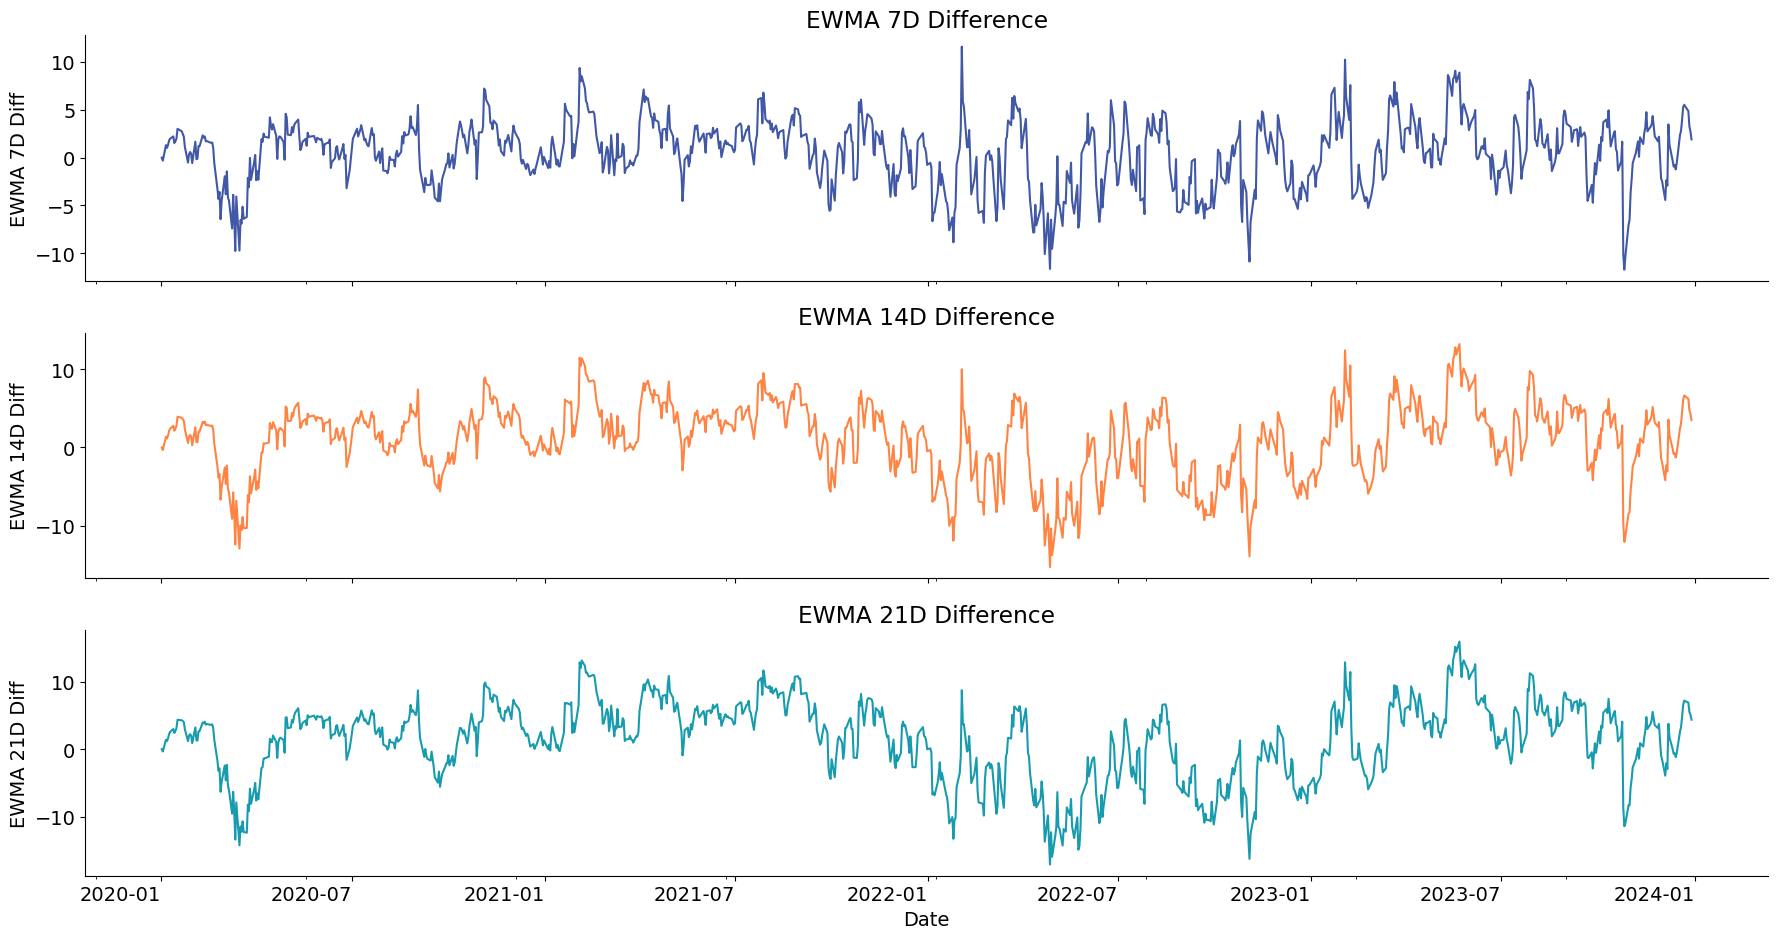

In [18]:
# Create a 1x3 grid of subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

# Plot each EWMA difference on a separate subplot
df.set_index('Date')['EWMA_7D_diff'].plot(ax=axs[0], color='#4158A6', title='EWMA 7D Difference')
axs[0].set_ylabel('EWMA 7D Diff')

df.set_index('Date')['EWMA_14D_diff'].plot(ax=axs[1], color='#FF8343', title='EWMA 14D Difference')
axs[1].set_ylabel('EWMA 14D Diff')

df.set_index('Date')['EWMA_21D_diff'].plot(ax=axs[2], color='#179BAE', title='EWMA 21D Difference')
axs[2].set_ylabel('EWMA 21D Diff')

# Adjust layout to prevent overlap and improve appearance
plt.tight_layout()

plt.xticks(rotation=0)

# Show the plot
plt.show()


In [19]:
def calc_range(col):
    q1, q3 = np.quantile(df[col].fillna(0), 0.25), np.quantile(df[col].fillna(0), 0.75)
    return round(q3 - q1, 2)

cols = ['Close_Pct_Change', f'{span}D_Pct_Return', f'{span}D_Momentum']

for col in cols:
    iqr = calc_range(col)  # Calculate IQR for the current column
    globals()[f"{col}_iqr"] = iqr  # Store the IQR in the global namespace
    print(f"{col} range : {iqr}")


Close_Pct_Change range : 2.16
14D_Pct_Return range : 0.09
14D_Momentum range : 8.99


2nd Approach of Making Predictions about tomorrow¶
The Relative Strength Index (RSI) is a popular momentum oscillator used in technical analysis to measure the speed and change of price movements. It helps traders assess whether a stock is overbought or oversold, which can signal potential reversals or entry/exit points. Here’s a deeper dive into RSI:

1. RSI Calculation:
RSI Formula: 
100 − (100/(1+RS))

RS (Relative Strength) is calculated as: 
RS= Average Gain / Average Loss

Average Gain and Average Loss are typically calculated over a 14-day period:

Average Gain: The average of all gains over the period.
Average Loss: The average of all losses over the period.
Steps to Calculate RSI:

Calculate Daily Price Changes: (\text{Change} = \text{Today's Close} - \text{Yesterday's Close}).
Separate Gains and Losses: Positive changes are gains, and negative changes are losses.
Calculate Average Gains and Losses: Use a 14-day period to calculate the average gains and losses.
Compute RS: (\text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}).
Calculate RSI: Use the RSI formula.
2. Interpretation of RSI:
Range: RSI values range from 0 to 100.
Overbought Conditions: An RSI above 70 is typically considered overbought, suggesting that the asset may be due for a correction or pullback.
Oversold Conditions: An RSI below 30 is typically considered oversold, suggesting that the asset may be due for a bounce or reversal.
3. Using RSI in Trading:
Buy Signal: When the RSI moves from below 30 to above 30, it may signal that the stock is recovering from oversold conditions and could be a good buying opportunity.
Sell Signal: When the RSI moves from above 70 to below 70, it may signal that the stock is coming off overbought conditions and could be a good selling opportunity.
Divergences: If the price is making new highs, but the RSI is not, it may indicate a bearish divergence and potential trend reversal. Conversely, if the price is making new lows but the RSI is not, it may indicate a bullish divergence.
4. Practical Example:
Suppose you are analyzing a stock and find that its RSI has recently fallen below 30. This may indicate that the stock is oversold and could be a potential buying opportunity if other indicators align.
Conversely, if the RSI rises above 70, it may suggest that the stock is overbought and could be a good point to consider selling or taking profits.
5. Adjustments:
Different Periods: While 14 days is the standard period used for RSI, you can adjust the period to suit different trading strategies or time frames (e.g., 7-day RSI for shorter-term trading).
Combining with Other Indicators: RSI is often used in conjunction with other technical indicators, like moving averages or MACD, to confirm signals and reduce false positives.
Summary:
RSI is a versatile tool for identifying potential overbought or oversold conditions, making it a valuable addition to any technical trader's toolkit. It helps traders make informed decisions by assessing price momentum and potential reversal points.



In [20]:
df['RSI'] = df.ta.rsi(close=df['Close'], length=span).fillna(0)
bb = df.ta.bbands(close=df['Close'], length=14, std=2.0)
df['BB_LBand'], df['BB_UBand'] = bb[f'BBL_{span}_2.0'], bb[f'BBU_{span}_2.0']
rsi_threshold_sell = 70
rsi_threshold_buy = 30
df['Combined_Sell_Signal'] = (df['Close'] > df['BB_UBand']) | (df['RSI'] > rsi_threshold_sell) | (df['EWMA_21D_diff'] < 0)
df['Combined_Buy_Signal'] = (df['Close'] < df['BB_LBand']) | (df['RSI'] < rsi_threshold_buy) | (df['EWMA_7D_diff'] > 0)

# Display RSI and Signal
df[['Date', 'RSI', 'Combined_Sell_Signal', 'Combined_Buy_Signal']].tail(20)


,Date,RSI,Combined_Sell_Signal,Combined_Buy_Signal
986,2023-12-01,44.970435,True,False
987,2023-12-04,39.732334,True,True
988,2023-12-05,44.366758,True,False
989,2023-12-06,42.387188,True,False
990,2023-12-07,57.078995,False,True
991,2023-12-08,52.993109,False,True
992,2023-12-11,49.639844,False,False
993,2023-12-12,48.153529,True,False
994,2023-12-13,48.261894,True,False
995,2023-12-14,46.931276,True,False


Using RSI also, we can tell the investors to not buy or sell at this time. The major trend is HOLD

MACD (Moving Average Convergence Divergence)
What it is: A momentum indicator showing the relationship between two EMAs.
Components:
MACD Line: Difference between a short-term (12-day) and long-term (26-day) EMA.
Signal Line: A 9-day EMA of the MACD line.
Histogram: Difference between MACD line and Signal line.
Interpretation:

Bullish: When the MACD line crosses above the Signal line (buy signal).
Bearish: When the MACD line crosses below the Signal line (sell signal).
Histogram: Wider bars indicate stronger momentum.


In [21]:
df[['MACD', 'MACD_SIGNAL', 'MACD_HIST']] = df.ta.macd(close=df['Close'], length=14).fillna(0)
df[['Date', 'Close', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']].tail()


,Date,Close,MACD,MACD_SIGNAL,MACD_HIST
1001,2023-12-22,140.978943,1.445046,0.860382,0.584663
1002,2023-12-26,141.008835,1.742772,0.926487,0.816285
1003,2023-12-27,139.862976,1.864765,0.838784,1.025981
1004,2023-12-28,139.723495,1.927965,0.721588,1.206378
1005,2023-12-29,139.185440,1.912589,0.564969,1.347620


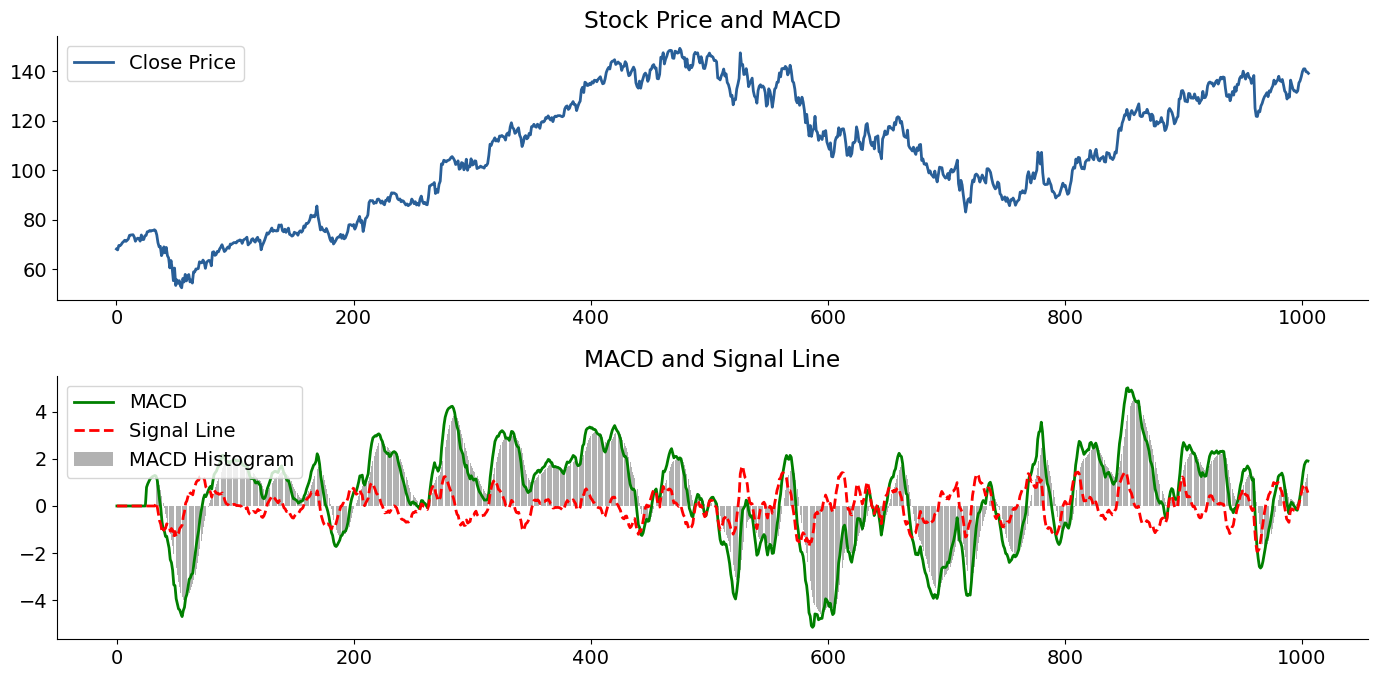

In [22]:
plt.figure(figsize=(14, 7))
    
# Plot the closing price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='#295F98', linewidth=2)
plt.title('Stock Price and MACD')
plt.legend(loc='upper left')

# Plot the MACD and Signal Line
plt.subplot(2, 1, 2)
plt.plot(df['MACD'], label='MACD', color='green', linewidth=2)
plt.plot(df['MACD_SIGNAL'], label='Signal Line', color='red', linestyle='--', linewidth=2)

# Plot the MACD Histogram
plt.bar(df.index, df['MACD_HIST'], label='MACD Histogram', color='gray', alpha=0.6)

plt.title('MACD and Signal Line')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Bollinger Bands¶
What it is: A volatility indicator consisting of a middle SMA and two outer bands that represent standard deviations from the middle.
Components:
Middle Band: A 20-day SMA.
Upper Band: Middle Band + 2 standard deviations.
Lower Band: Middle Band - 2 standard deviations.
Interpretation:

Overbought: Price touches or exceeds the upper band.
Oversold: Price touches or dips below the lower band.
Bollinger Squeeze: Narrow bands indicate low volatility, potentially signaling an upcoming breakout.


In [23]:
# Display the last few rows to check the calculated bands
df[['Date', 'Close', 'BB_LBand', 'BB_UBand']].tail()


,Date,Close,BB_LBand,BB_UBand
1001,2023-12-22,140.978943,127.660331,141.158040
1002,2023-12-26,141.008835,127.988096,142.329126
1003,2023-12-27,139.862976,129.070072,142.720376
1004,2023-12-28,139.723495,129.026144,143.234031
1005,2023-12-29,139.185440,129.258433,143.670746


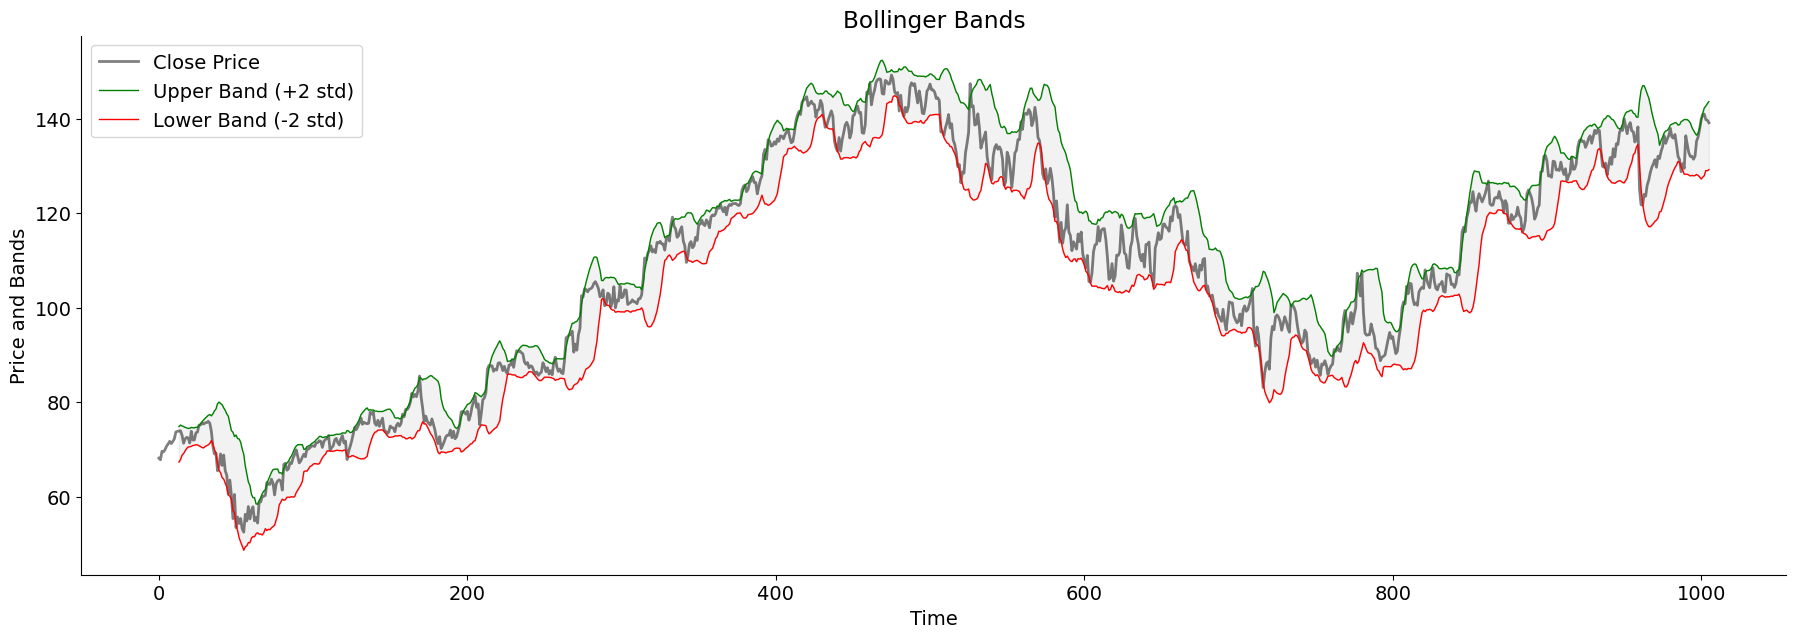

In [24]:
def plot_bollinger_bands(data):
    plt.figure(figsize=(22, 7))
    
    # Plot the closing price
    plt.plot(data['Close'], label='Close Price', color='black', linewidth=2, alpha=0.5)
    
    # Plot the Middle, Upper, and Lower Bands
    plt.plot(data['BB_UBand'], label='Upper Band (+2 std)', color='green', linewidth=1)
    plt.plot(data['BB_LBand'], label='Lower Band (-2 std)', color='red', linewidth=1)
    
    # Shade the area between the upper and lower bands
    plt.fill_between(data.index, data['BB_UBand'], data['BB_LBand'], color='gray', alpha=0.1)
    plt.xlabel('Time')
    plt.ylabel('Price and Bands')
    plt.title('Bollinger Bands')
    plt.legend(loc='upper left')
    plt.show()

# Example usage:
plot_bollinger_bands(df)


Interpretation of the Plot:

Overbought: When the price is near or touches the upper band, it could signal a potential reversal or correction.
Oversold: When the price is near or dips below the lower band, it could signal a potential upward reversal.
Bollinger Squeeze: A narrowing of the bands indicates a period of low volatility, which could signal a breakout (up or down) is coming soon.
Practical Use Cases:

Buy Signal: When the price touches the lower band and starts moving up, it could indicate a potential buy opportunity.
Sell Signal: When the price touches the upper band and starts moving down, it could indicate a potential sell opportunity.
Breakout: A Bollinger Squeeze often signals a significant price movement is imminent. Watch for price movement direction after the squeeze.
Bollinger Bands can be used in combination with other indicators like MACD or RSI to confirm signals and improve prediction accuracy.

Mo

Modelling¶
Let's move on to the modelling part now.

Importance of ARMA and ARIMA
Improved Decision-Making: Accurate forecasts empower businesses and policymakers to make informed decisions, optimize resources, and manage risks.
Economic and Financial Applications: Widely used to predict stock prices, interest rates, and economic indicators, assisting in investment and policy strategies.
Operational Efficiency: In inventory and supply chain management, these models predict demand, reduce costs, and enhance customer satisfaction.
Strategic Planning: ARIMA-based long-term forecasts support strategic planning, helping organizations anticipate trends and challenges.
By utilizing the predictive power of ARMA and ARIMA models, organizations can gain a competitive advantage and improve both operational and strategic outcomes.

Let's start by importing the necessary libraries, including those for data visualization and management.

ARMA
ARMA as we discussed earlier is a statistical model for forecasting the future values based on lagged (historical) values. It comprises of two parts:-

Auto Regressive (AR)
Moving Average (MA)
Auto-Regressive (AR)
A Statistical model that tries to predict the values based on lagged values and the lag could be chosen as per the wish.

The AR part of the model involves regressing the variable on its own lagged (past) values. The order of the AR part is denoted by p

AR model takes into account all the lags meaning 7 and 9

For Example: Sales of 9th month could be predicted based on 7th and 8th Month.

The AR part of the model is calculated by the below formula:-

Xt=c+ϕ1Xt−1+ϕ2Xt−2+ϕ3Xt−3+⋯+ϕpXt−p+ϵt
Where:

Xt is the value of the series at time t.
c is the constant term (intercept).
ϕi (for i=1,2,…,p) are the coefficients (calculated using OLS method) of the lagged values.
Xt−i are the lagged values of the series. (t-1 is the 1st lag, t-2 is the 2nd lag from the original series and so on)
ϵt is the error term (white noise) at time t.
In an AR model, the coefficients (ϕ1, ϕ2 etc.) act as weights assigned to each lagged value. A larger coefficient indicates a stronger influence of that particular lag on the current prediction.

For example, for an AR(2) model (where p=2), the equation would be:

Xt=c+ϕ1Xt−1+ϕ2Xt−2+ϵt
This explicitly shows that 
Xt depends on the two most recent past values of the series, 
Xt−1 and Xt−2.

Similarly, for an AR(n) model (where p = infinity ), the equation would be:

Xt=c+ϕ1Xt−1+ϕ2Xt−2+…+ϕnXt−n+ϵt
Intercept (c) and Error Term (ϵt)
Intercept (c):

The intercept term 
c in the above equation accounts for the baseline level of the dependent variable when all independent variables are zero.

It allows the regression line to fit the data correctly, instead of forcing it through the origin. Using a column of ones ensures accurate estimation of this baseline value.

High intercept values can lead to skewed results and inaccurate predictions.

Error Term (ϵt):

The error term represents the difference between observed and predicted values. Linear regression aims to minimize the sum of squared error terms using the least squares method.

The normal equation XT⋅X⋅b=XT⋅y calculates the coefficients 
b that minimize these residuals, addressing the error term and ensuring a better fit.

How do we get the coefficients (c) and (ϕ1,2,3...n)
When trying to find the coefficients in the equation 
Xt=c+ϕ1Xt−1+ϕ2Xt−2+ϕ3Xt−3+⋯+ϕpXt−p+ϵt, we essentially are trying to solve for b (in the equation below) which is effectively your coefficients (c) and (ϕ12,3...n)

Xt⋅X⋅b=XT⋅y

By solving for b ( the exact equation becomes b=(XT⋅X)−1⋅XT⋅y ), we get a vector of intercept and coefficients. The intercept is the first element and the rest of the values in the vector are the coefficients of the lags starting from 1 going upto 
n lags.

Note :- X is our lagged values along with the intercept value and y will be our actual / original series



Partial Autocorrelation Function (PACF)¶
So even before going into what's Partial Autocorrelation Function let's understand why we are using it. First of all, we need to find how many lagged values we are going to be needing to prepare a model and how we do that is by plottng a PACF plot.

We will be using the Close values for determining the lags for the AR model (p value in the p, d and q series of parameters that's to be given to ARMA and ARIMA)

What is PACF?
The Partial Autocorrelation Function (PACF) measures the correlation between the time series and its lagged values, but it removes the effects of the intermediate lags. It’s like filtering out the middle steps to see the direct relationship. For example : if its comparing the 8th and the 11th lag it's not going to consider other lags will define the relationship between these 2 lags only and not considering the effect of the 9th and 10th lag

Why is PACF Important?
It helps us determine the number of Autoregressive (AR) p terms in an ARIMA model.
Example - Using the same daily temperature example, the PACF will show the direct relationship between today’s temperature and the temperature two days ago, without being influenced by yesterday’s temperature.

How to Read a PACF Plot
The x-axis represents the lag.
The y-axis represents the partial correlation.
A significant spike at lag k suggests that the value k days ago has a direct relationship with today’s value, independent of the values in between.
Let's plot one below and see what value of p are we going to get.



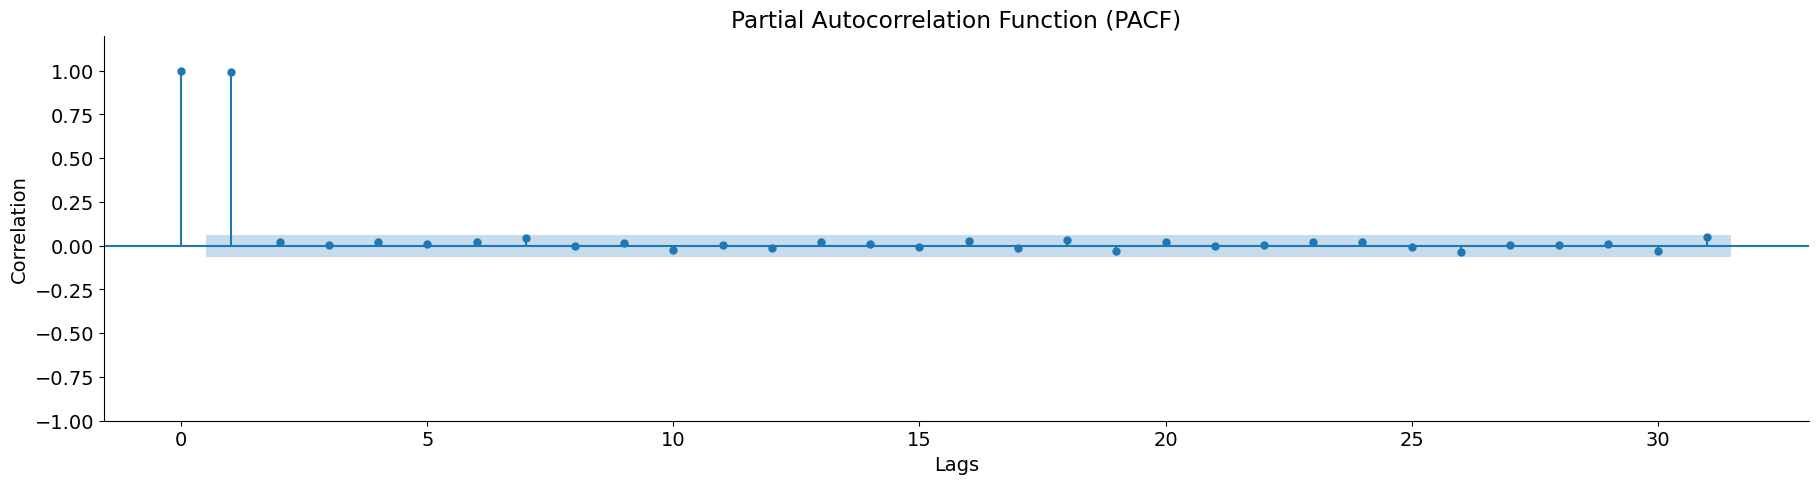

In [25]:
plot_pacf(df['Close']) #pacf tells p (AR)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.ylim(top=1.2)
plt.show()


Now if we were to get the lags here is what we would do:-

Take a look at the correlation values. Starting from the left (the value at 0th lag is the orginal series at time t), stop where the correlation value is less than 0.05 (5% significance)
In this case the series has a high significance value of the lag at first lag and hence we will take lag = 1
We didn't take 2nd lag because its statistically insignificant (less than 0.05 correlation).
PS : - both the partial autocorrelation function (PACF) and the autocorrelation function (ACF) calculate correlations using the Pearson correlation coefficient. This coefficient measures the linear relationship between two variables in a dataset. When applied to time series analysis, it provides valuable insights into the relationship between a variable and its lagged values, aiding in identifying patterns and dependencies within the data.

First of all let's find out how we can get the PACF Values and then We will use pandas to shift the values by 1 and 2 rows and use numpy to solve for the coefficients that will help us make the predictions.

pacf_values = pacf(df['Close'])


In [26]:
pacf_values = pacf(df['Close'])

# Print PACF values
print("PACF Values:", pacf_values)


PACF Values: [ 1.          0.9952728   0.02680492  0.00684868  0.02638184  0.01119362
  0.02772834  0.05641785  0.00204107  0.02017281 -0.02985537  0.00504282
 -0.01560447  0.02868502  0.01410711 -0.00909656  0.03232716 -0.01677888
  0.03873273 -0.03472272  0.02770938  0.00165285  0.00551465  0.02637473
  0.02594834 -0.00658003 -0.04151801  0.0042625   0.00476461  0.00971411
 -0.03769994]


In [27]:
#shifting the data by 1 and 2 rows, shifting would mean pushing the data n rows forward
df['Close_Lag_1'], df['Close_Lag_2'] = df['Close'].shift(1), df['Close'].shift(2)

#Dropping the rows where the values are NaN because they couldn't be filled when shifted by 1 or 2 rows
df.dropna(inplace=True)

#create a new df with the original series, 1 lagged and 2 lagged values
df_lagged = df[['Close','Close_Lag_1', 'Close_Lag_2']]

#Creating an input dataframe
X = df_lagged[['Close_Lag_1', 'Close_Lag_2']]
X['Intercept'] = 1

#Output (target) series
y = df_lagged['Close']
#Dataframe until now


In [28]:
#Dataframe until now
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EWMA_7D,EWMA_7D_diff,...,RSI,BB_LBand,BB_UBand,Combined_Sell_Signal,Combined_Buy_Signal,MACD,MACD_SIGNAL,MACD_HIST,Close_Lag_1,Close_Lag_2
13,2020-01-22,74.217455,74.757991,73.865232,73.925507,28458000,0.0,0.0,71.446910,2.478596,...,0.000000,67.341706,74.875102,False,True,0.0,0.0,0.0,73.844803,73.708801
14,2020-01-23,74.108851,74.405277,73.748653,73.966362,26650000,0.0,0.0,71.761842,2.204520,...,89.050367,67.860459,75.181999,True,True,0.0,0.0,0.0,73.925507,73.844803
15,2020-01-24,74.371400,74.440151,72.894751,73.043716,29786000,0.0,0.0,71.922076,1.121640,...,73.060691,68.792644,74.994615,True,True,0.0,0.0,0.0,73.966362,73.925507
16,2020-01-27,71.318470,71.569559,70.718639,71.327934,34132000,0.0,0.0,71.847808,-0.519874,...,53.737025,69.151529,74.877141,False,False,0.0,0.0,0.0,73.043716,73.966362
17,2020-01-28,71.826625,72.477266,71.259680,72.263046,29724000,0.0,0.0,71.899713,0.363333,...,59.953652,69.710089,74.712795,False,True,0.0,0.0,0.0,71.327934,73.043716


In [29]:
#Inputs to the model
X.head()


,Close_Lag_1,Close_Lag_2,Intercept
13,73.844803,73.708801,1
14,73.925507,73.844803,1
15,73.966362,73.925507,1
16,73.043716,73.966362,1
17,71.327934,73.043716,1


In [30]:
#Outputs expected
y.head()


13    73.925507
14    73.966362
15    73.043716
16    71.327934
17    72.263046
Name: Close, dtype: float64

In [66]:
LHS = np.dot(X.T, X)
RHS = np.dot(X.T, y)
#Coefficient for lags (first 2, third is constant term) calculated using ordinary least squares implemented in Numpy
coeffs = np.linalg.solve(LHS, RHS) # AR(2)
#Assigning the values
lag1_coeff, lag2_coeff, c = coeffs # type: ignore
print('Lag 1 Coeff :', round(lag1_coeff,4))
print('Lag 2 Coeff :', round(lag2_coeff,4))
print('Constant Value :', round(c,4))


Lag 1 Coeff : 0.9517
Lag 2 Coeff : 0.0446
Constant Value : 0.0044


In [32]:
#Helper Function to predict the values using just the AR Model
def predict_ar2(X_t_minus_1, X_t_minus_2, c, phi_1, phi_2):

    #Whatever we are returning is the equation for an AR(2) model
    return c + phi_1 * X_t_minus_1 + phi_2 * X_t_minus_2


In [33]:
#Adding a new column for the AR predictions
df['AR_Preds'] = predict_ar2(df['Close_Lag_1'], df['Close_Lag_2'], c, lag1_coeff, lag2_coeff)

#Probability or say confidence of the Prediction made by the AR model
df['Pred_Prob'] =  round(1/(1 + np.exp(-df['AR_Preds']))*100,2)


In [34]:
df[['Date', 'Close', 'AR_Preds', 'Pred_Prob']]


,Date,Close,AR_Preds,Pred_Prob
13,2020-01-22,73.925507,74.036026,100.0
14,2020-01-23,73.966362,74.118889,100.0
15,2020-01-24,73.043716,74.161366,100.0
16,2020-01-27,71.327934,73.285134,100.0
17,2020-01-28,72.263046,71.611169,100.0
...,...,...,...,...
1001,2023-12-22,140.978943,139.768357,100.0
1002,2023-12-26,141.008835,140.875320,100.0
1003,2023-12-27,139.862976,140.951272,100.0
1004,2023-12-28,139.723495,139.862127,100.0


In [35]:
conf = round(df['Pred_Prob'].mean(),2)
residuals = df['Close'] - df['AR_Preds']
ssr = round(np.sum(residuals**2),2)
print(f"The model is {conf}% confident in the predictions made by the AR Model")
print(f"Sum of Squares of Residuals (SSR): {ssr}")


The model is 100.0% confident in the predictions made by the AR Model
Sum of Squares of Residuals (SSR): 4615.53


The Sum Of Squares value calculated above is what we are trying to minimize by calculating the b value in the equation  
X^t ⋅ X ⋅ b = X^T ⋅ y .

Let's see how well the model did by plotting the predictions made by the Auto-Regressive Models and the actual values

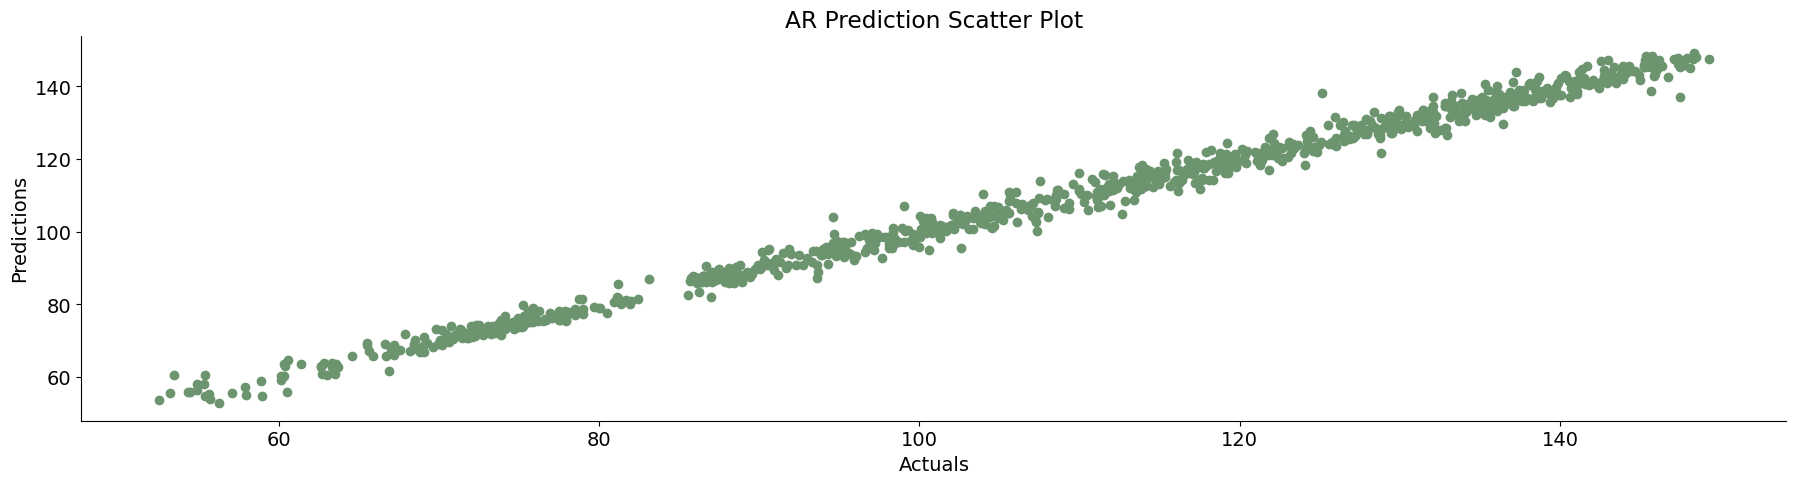

In [36]:
plt.scatter(df['Close'], df['AR_Preds'], color='#6C946F')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('AR Prediction Scatter Plot')
plt.show()


So the values here 0.9517, 0.0466 are the coefficient of lags (2 here) which then gets multiplied by the lagged value of the series and gets summed up (add an random error too) to get the value at the current time stamp. Let's also take a look at the Mean Squared Error to find out how close or far we are from the actual values.



In [37]:
MSE = float(round(mean_squared_error(df['Close'], df['AR_Preds']),2))
print(f"The Mean Squared Error for the AR model here is {MSE}.")


The Mean Squared Error for the AR model here is 4.65.


Does Changing the Lag Order in the AR Model affect the results?¶
Yes, changing the order of the lags in the autoregressive model equation will impact the final result. This is because the coefficients ϕi in an AR model are specifically tied to particular lagged values of the time series, representing their respective influences on the current value Xt.

In an AR(p) model, each coefficient ϕi is associated with a specific lag. The model captures the relationship between 
Xt and its past values:

Xt=c+ϕ1Xt−1+ϕ2Xt−2+⋯+ϕpXt−p+ϵt
If you change the order of the lags, such as 
Xt=c+ϕ1Xt−2+ϕ2Xt−3+ϕ3Xt−1+⋯+ϕpXt−p+ϵt you are altering which lagged value is associated with which coefficient. 

This means:

Different Relationships: The model will now capture different relationships between 
Xt and its past values. For example, 
ϕ1 will now be the coefficient for 
Xt−2 instead of Xt−1.

Estimation Changes: When you estimate the parameters using a method like ordinary least squares, the estimated coefficients will change because the input data (lagged values) for each coefficient has changed.

Prediction Impact: The predictive capability of the model will be different because the model is now using different past values to make predictions about the future.

As we discussed earlier, there is a Partial Correlation function. Close to the same, we have an Autocorrelation Function as well which gives us the q value which is for the Moving Average (MA) model.

Autocorrelation Function (ACF)
The Autocorrelation Function (ACF) helps us understand how current values of a time series are related to its past values. Think of it as a measure of how much past values influence the current value. ACF will consider other lags as well while defining the relationship between two lags say, 1st and 4th lag which means 2nd and 3rd lag are also going to get reeled in while determing the relationship between these 2 (1st and 4th) lags.

Why is ACF Important?
It helps us identify patterns in the data.
It’s used to determine the number of Moving Average (MA) q terms in an ARIMA model.
The equation that we use for Moving Average (MA) Model is :-

Xt=μ+ϵt+θ1ϵt−1+θ2ϵt−2+…+θqϵt−q
wher,
Xt = The current value of the time series.
μ = The mean of the series (constant term).
ϵt = The error term at time 
t (white noise).θi = Coefficients for each lagged error term.
q = The order of the MA model, indicating the number of lagged error terms included.

Example - Imagine you have a series of daily temperatures. The ACF will tell you if today’s temperature is related to yesterday’s temperature, the temperature two days ago, and so on.

How to Read an ACF Plot

The x-axis represents the lag (how far back you look).

The y-axis represents the correlation (how strong the relationship is).

A significant spike at lag k suggests that the value k days ago has a strong relationship with today’s value.

In the MA model, the future value is predicted based on past errors or random shocks. Here's how it works:

Error Terms: These are the differences between what you predicted and what actually happened in the past. They capture random fluctuations or unexpected changes.

Using Errors: By looking at these past errors, the model adjusts future predictions. If something unexpected happened in the past, it might affect the future in a predictable way.

Why Use Errors?
Patterns in Noise: Sometimes, the random changes (errors) have patterns. By using these patterns, you can make better predictions.

Corrective Measures: If past predictions were off due to random factors, using errors helps correct future predictions.

Example - Imagine you’re forecasting sales. If sales were unexpectedly high last week (an error), it might suggest a trend or a temporary spike that could affect this week's sales. The model uses this information to adjust its forecast.

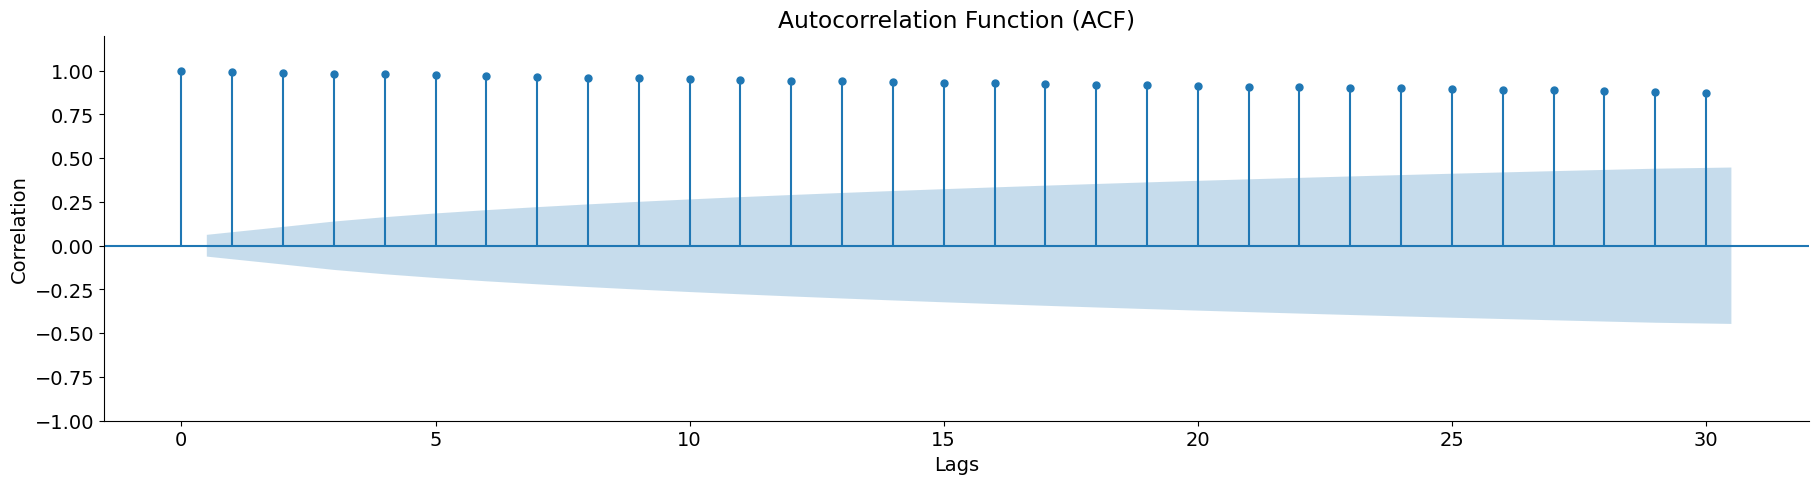

In [38]:
plot_acf(df['Close']) #acf tells q (MA)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Function (ACF)')
plt.ylim(top=1.2)
plt.show()


We see in the ACF plot above that all the lagged value seem to be strongly correlated with other lags. If the ACF values remain close to 1 for all lags, it suggests that there is a strong persistence in the series.

This pattern is unusual for a typical Moving Average (MA) process, where we usually expect the ACF to drop off after a certain number of lags.

Let's also see how we can fetch the Auto-Correlation Function Values:-



In [39]:
acf_values = acf(df['Close'], nlags=len(df['Close'])-1)

# Print ACF values
print("ACF Values:", acf_values)


ACF Values: [ 1.00000000e+00  9.94464410e-01  9.89247936e-01  9.83956112e-01
  9.78859703e-01  9.73903317e-01  9.69197833e-01  9.64996851e-01
  9.60699279e-01  9.56757413e-01  9.52365567e-01  9.48004324e-01
  9.43461344e-01  9.39205569e-01  9.35159089e-01  9.31038648e-01
  9.27356435e-01  9.23593388e-01  9.20188742e-01  9.16364448e-01
  9.12866777e-01  9.09390600e-01  9.05727272e-01  9.02265823e-01
  8.98910692e-01  8.95437041e-01  8.91280513e-01  8.87200011e-01
  8.83223903e-01  8.79198463e-01  8.74925661e-01  8.71102800e-01
  8.66911131e-01  8.62551519e-01  8.58611360e-01  8.54440913e-01
  8.49376580e-01  8.44603129e-01  8.39445779e-01  8.34342423e-01
  8.29408978e-01  8.24960402e-01  8.20764523e-01  8.16090268e-01
  8.11458679e-01  8.06674863e-01  8.01530559e-01  7.95575355e-01
  7.89585563e-01  7.84042140e-01  7.78457375e-01  7.72731099e-01
  7.66675725e-01  7.60579971e-01  7.54138251e-01  7.47730589e-01
  7.41316698e-01  7.35130515e-01  7.29316028e-01  7.23954290e-01
  7.18688111e

Let's try and understand why we are getting all the lags as significant lags.

Non-Stationary Series: ACF values close to 1 at all lags usually indicate a non-stationary series. Non-stationary series have trends or other structures that cause the high correlations at different lags. In such cases, differencing the series might be necessary to achieve stationarity before determining the MA order.

ARIMA Model: If the series is non-stationary, you might need to fit an ARIMA model instead of just an MA model. The I (Integrated) part of ARIMA accounts for differencing to make the series stationary.

What can we do now to resolve this issue?

Check for Stationarity:

Perform a stationarity test such as the Augmented Dickey-Fuller (ADF) test.
Plot the time series to visually inspect for trends.
Differencing: - If the series is non-stationary, apply differencing (e.g., first difference) and then re-calculate the ACF.

Re-evaluate the ACF: - After differencing, plot the ACF again to determine if the series is now stationary and the ACF shows a meaningful cut-off for determining  q .

Determining  q :
After differencing, the ACF of the differenced series should ideally show a clear pattern where the correlations drop off after a certain lag. The lag at which the ACF first becomes zero (or close to zero) and stays there can help determine the order  q  for the MA part of the ARIMA model.

If the ACF values after differencing show a sharp cut-off, that cut-off point is your  q . If the ACF values still do not show a clear cut-off, you may need to investigate further or consider other aspects of the series, such as seasonality or more complex model structures.

So now lets get the differenced series and what is the lag that should be used for q values for the MA Model.

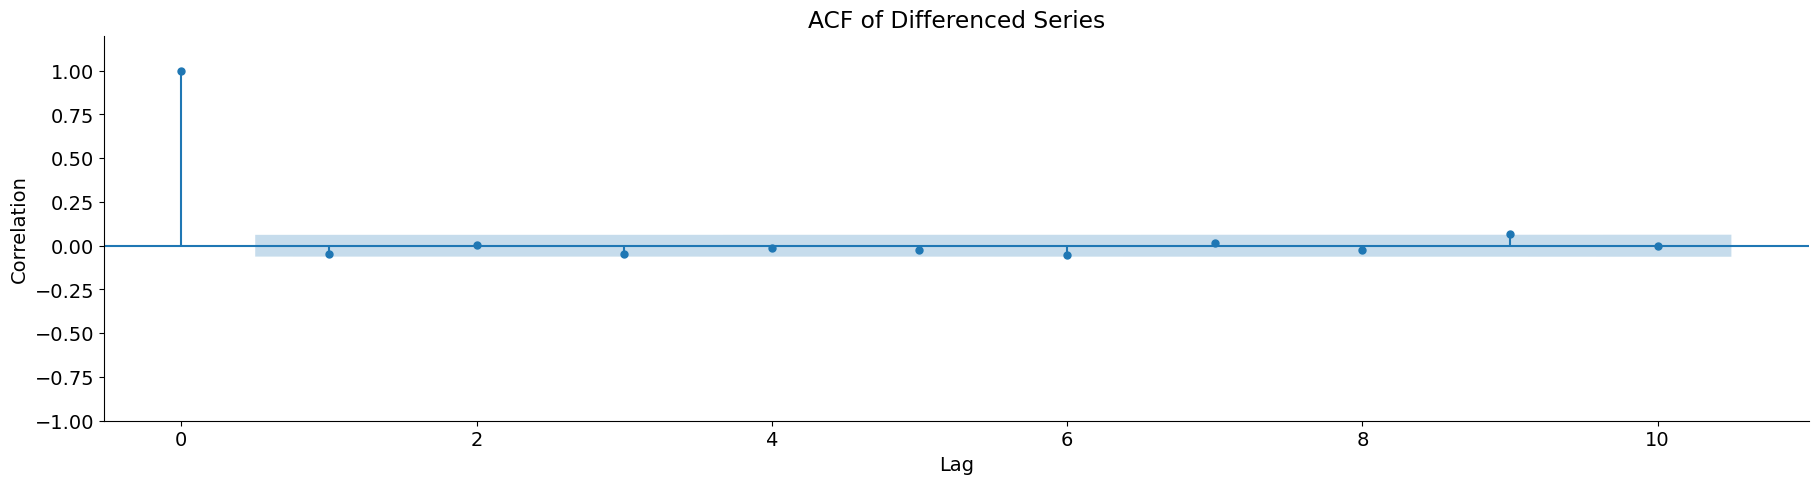

In [40]:
# If non-stationary, apply differencing
differenced_series = np.diff(df['Close'], n=1)

# Plot ACF of differenced series
plot_acf(differenced_series, lags=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('ACF of Differenced Series')
plt.ylim(top=1.2)
plt.show()


So now we can see that after differencing the series once, we can easily decide on the number of lags (q value) to use for the Moving Average (MA) model.

When we difference our series, the ACF (Autocorrelation Function) plot helps us see if the series is now stationary. If the ACF plot shows a spike at lag 0 (with a correlation of 1) and all other lags are insignificant, it means that differencing has successfully removed the non-stationarity.

Understanding the ACF Plot After Differencing:
Lag 0 Correlation: A spike at lag 0 with a correlation of 1 is normal. It shows that the differenced series is perfectly correlated with itself at lag 0.
Insignificant Correlations at Other Lags: If other lags have insignificant correlations (i.e., they fall within the confidence interval), it means there's no significant autocorrelation at those lags. This suggests the differenced series is stationary.
Deciding on  
q  for the MA Model:
If the ACF plot of the differenced series shows no significant spikes beyond lag 0, it suggests that we might not need an MA component, or the MA order (q) could be very small, potentially zero.

In other words, if there are no significant autocorrelations in the differenced series, a Moving Average (MA) model with q = 0 might be enough. However, it's usually a good idea to check other diagnostics and use criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to confirm the best model order.

Next Steps:
Fit an ARIMA Model: Since there are no significant autocorrelations, you can start with a low q value, like q = 0, and see how well the model fits.
Use Model Selection Criteria: Use AIC or BIC to compare different models and choose the best one.
Model Diagnostics: Check the residuals (errors) of the fitted model to ensure they look like random noise.
Adjusting  
p ,  d ,  q :

p : Number of autoregressive terms (how many past values to use).

d : Number of times you differenced the series to make it stationary.

q : Number of lagged forecast errors in the prediction equation.

When the ACF plot of the differenced series shows no significant spikes beyond lag 0, you might start with q = 0. You can then experiment with different values of p and d to find the best model.



In [41]:
X.loc[:, 'Intercept'] = round(df['Close'].mean(),2)


In [42]:
X.head()


,Close_Lag_1,Close_Lag_2,Intercept
13,73.844803,73.708801,107.96
14,73.925507,73.844803,107.96
15,73.966362,73.925507,107.96
16,73.043716,73.966362,107.96
17,71.327934,73.043716,107.96


In [43]:
y.head()


13    73.925507
14    73.966362
15    73.043716
16    71.327934
17    72.263046
Name: Close, dtype: float64

In [45]:
# data: Time series of observed values
observed_values = np.array(df['Close'].values)

# Define parameters
q = 2  # Order of the MA model
errors = np.zeros_like(observed_values)  # Initial error terms

# Initialize lagged errors matrix and response vector
lagged_errors = []
responses = []

# Calculate initial errors (assuming mean is a simple baseline)
mu = np.mean(observed_values)
errors[:q] = observed_values[:q] - mu

# Prepare data for least squares estimation
for t in range(q, len(observed_values)):

    # We reverse the error lags / Last Element in Error Lag Array = Most Recent Error Lag
    error = errors[t-q:t][::-1]
    lagged_errors.append(error)
    
    #Removing the median = Removing the baseline = Focus on Actual Fluctuation b/w prediction and actual value
    values =  observed_values[t] - mu
    responses.append(values)

# Convert to NumPy arrays
lagged_errors = np.array(lagged_errors)
responses = np.array(responses)

# Calculate theta using least squares
theta, _, _, _ = np.linalg.lstsq(lagged_errors, responses, rcond=None)

print("Estimated MA coefficients (theta):", theta)

# Calculate errors and predicted values
predicted_values = np.zeros_like(observed_values)
for t in range(q, len(observed_values)):
    predicted_values[t] = mu + np.dot(theta, errors[t-q:t][::-1])
    errors[t] = observed_values[t] - predicted_values[t]



Estimated MA coefficients (theta): [-0.05176933  1.07761619]


In [46]:
lagged_errors


array([[-33.99326702, -34.03412243],
       [  0.        , -33.99326702],
       [  0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [47]:
responses


array([-3.49159126e+01, -3.66316948e+01, -3.56965828e+01, -3.53877067e+01,
       -3.55097694e+01, -3.65793876e+01, -3.40973930e+01, -3.59501686e+01,
       -3.59182853e+01, -3.44276924e+01, -3.42712516e+01, -3.27990913e+01,
       -3.27293434e+01, -3.23023872e+01, -3.25634422e+01, -3.22974128e+01,
       -3.22620353e+01, -3.19915199e+01, -3.23840980e+01, -3.40545463e+01,
       -3.72230568e+01, -3.88939933e+01, -3.86872444e+01, -4.24496116e+01,
       -4.12389946e+01, -3.88939933e+01, -4.13152198e+01, -3.91291389e+01,
       -4.24590721e+01, -4.34066352e+01, -4.73896980e+01, -4.44314232e+01,
       -4.76333198e+01, -5.25828743e+01, -4.74654235e+01, -5.45034141e+01,
       -5.22585525e+01, -5.35971946e+01, -5.25768966e+01, -5.47420501e+01,
       -5.54435043e+01, -5.16632080e+01, -5.30775833e+01, -5.00236511e+01,
       -5.26471443e+01, -5.08511505e+01, -5.00719757e+01, -5.30536689e+01,
       -5.23098602e+01, -5.35219726e+01, -4.90138092e+01, -4.90452003e+01,
       -4.78276138e+01, -

In [48]:
observed_values


array([ 73.92550659,  73.966362  ,  73.04371643,  71.32793427,
        72.26304626,  72.5719223 ,  72.44985962,  71.38024139,
        73.86223602,  72.00946045,  72.04134369,  73.53193665,
        73.68837738,  75.16053772,  75.23028564,  75.65724182,
        75.39618683,  75.66221619,  75.69759369,  75.96810913,
        75.57553101,  73.9050827 ,  70.73657227,  69.06563568,
        69.27238464,  65.5100174 ,  66.72063446,  69.06563568,
        66.64440918,  68.83049011,  65.50055695,  64.55299377,
        60.56993103,  63.52820587,  60.3263092 ,  55.37675476,
        60.49420547,  53.4562149 ,  55.70107651,  54.36243439,
        55.38273239,  53.21757889,  52.51612473,  56.29642105,
        54.88204575,  57.93597794,  55.31248474,  57.10847855,
        57.88765335,  54.90596008,  55.64976883,  54.4376564 ,
        58.94581985,  58.91442871,  60.13201523,  60.11059189,
        60.30190277,  63.03300095,  62.63793182,  62.64440536,
        63.71901321,  62.82973862,  60.38908768,  62.69

In [49]:
predicted_values


array([ 0.00000000e+00,  0.00000000e+00,  7.30437164e+01,  7.13279343e+01,
        1.07959629e+02,  1.09807617e+02,  7.14200806e+01,  6.77805306e+01,
        1.08882981e+02,  1.13651736e+02,  7.23765001e+01,  6.31025896e+01,
        1.07058539e+02,  1.20926013e+02,  7.43686509e+01,  5.85974058e+01,
        1.08004964e+02,  1.28031719e+02,  7.55310166e+01,  5.15167815e+01,
        1.06873306e+02,  1.35929040e+02,  7.74435784e+01,  4.14688257e+01,
        9.93033823e+01,  1.39253083e+02,  7.94153688e+01,  2.91501061e+01,
        9.22131776e+01,  1.52296928e+02,  8.47273117e+01,  1.90102010e+01,
        8.48828471e+01,  1.58295943e+02,  8.66656993e+01,  7.19995414e+00,
        7.70817953e+01,  1.60734458e+02,  9.56382964e+01, -5.57761859e+00,
        6.18195782e+01,  1.72885231e+02,  1.07218294e+02, -1.81642758e+01,
        4.51569059e+01,  1.87696217e+02,  1.25157198e+02, -2.82562912e+01,
        2.82745591e+01,  1.98417037e+02,  1.47300651e+02, -4.19455252e+01,
        4.20546253e+00,  

In [50]:
#Probability or say confidence of the Prediction made by the AR model
probabilites = 1/(1 + np.exp(-predicted_values))
conf = round(np.mean(probabilites)*100,2)
mse = mean_squared_error(observed_values, predicted_values)
print(f"The model is {conf}% confident in the predictions made by the MA Model")
print(f'The Mean Squared Error between Observed And Predicted Value by MA Model is {round(MSE,4)}.')


The model is 52.58% confident in the predictions made by the MA Model
The Mean Squared Error between Observed And Predicted Value by MA Model is 4.65.


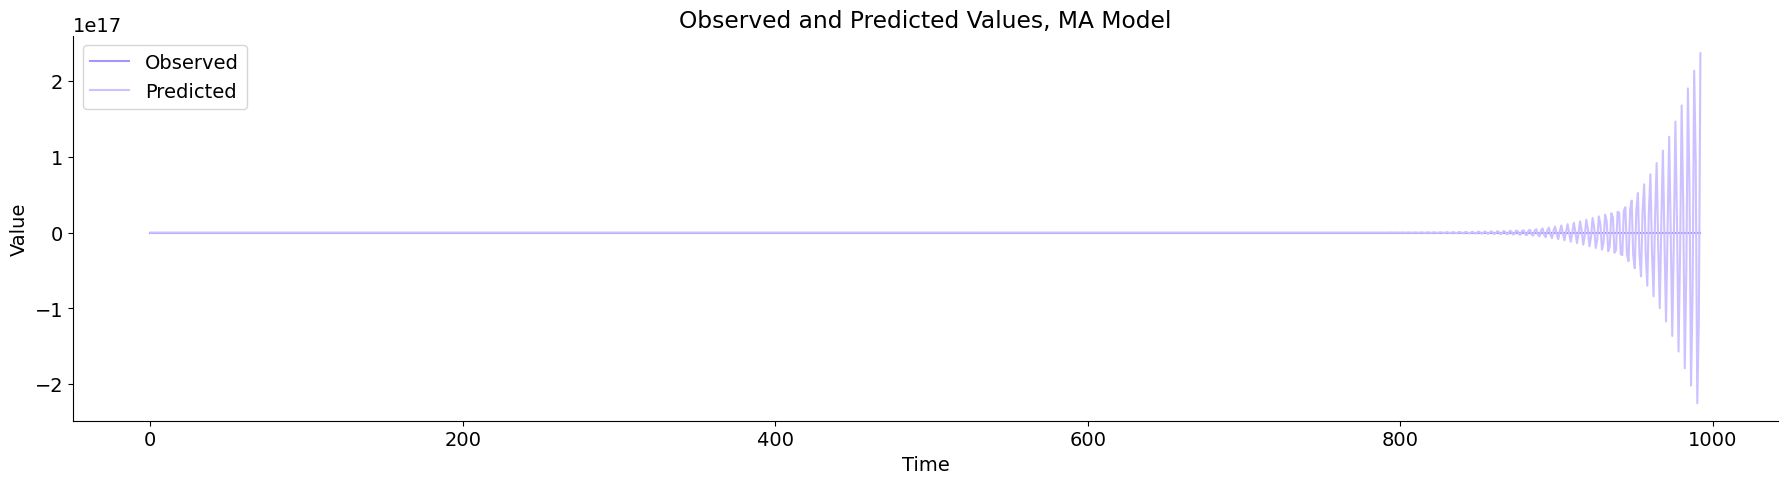

In [51]:
# Plot the results
plt.plot(observed_values, label='Observed', color='#A594F9')
plt.plot(predicted_values, label='Predicted', color='#CDC1FF')
plt.savefig('MA.jpg')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Observed and Predicted Values, MA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


How to Use ACF and PACF for ARMA and ARIMA Modeling¶
ARMA : AR (p) - MA (q)
ARIMA : AR (p) - I (d) - MA (q)
Identify AR Order (p):

Look at the PACF plot.
Find where the PACF cuts off (suddenly drops to near zero) – this lag is the AR order (p).

Identify MA Order (q):
Look at the ACF plot.
Find where the ACF cuts off – this lag is the MA order (q).

Identify Differencing Order (d):
Check if your time series is stationary (its statistical properties do not change over time).
If not, determine how many times you need to difference the data to make it stationary.

Conclusion
ACF helps you see how past values influence the current value.
PACF helps you see the direct relationship between past values and the current value, filtering out the middle steps.
Together, ACF and PACF help you decide the parameters (p and q) for your ARIMA model.
ARMA
So now we have got our p and q values for the ARMA model let's go ahead and make some predictions to see how close we got with the values we picked out.

However there is something to note here that the statsmodel library has deprecated. As of today, the statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have been removed in favor of statsmodels.tsa.arima.model.ARIMA (without _) and statsmodels.tsa.SARIMAX.

This is because statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and they're both well tested and maintained. It also offers alternative specialized parameter estimators.

If you try to use ARMA from statsmodels.tsa.arima_model you'll get NotImplementedError message error so we will just import ARIMA from statsmodels.tsa.arima.model and use 0 for d parameter

In [52]:
model = ARIMA(df['Close'], order=(1,0,0))
fitted_model = model.fit()


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
fitted_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  993
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2176.654
Date:                Tue, 04 Feb 2025   AIC                           4359.308
Time:                        14:57:41   BIC                           4374.011
Sample:                             0   HQIC                          4364.898
                                - 993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.9258     15.090      7.152      0.000      78.351     137.501
ar.L1          0.9968      0.003    355.803      0.000       0.991       1.002
sigma2         4.6695      0.135     34.604      0.000       4.405       4.934
===================================================================================
Ljung-Box (L1) (Q):                   2.01   Jarque-Bera (JB):               352.32
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the summary above, we can see few terms like AIC and BIC. Let's understand what that means:-

AIC (Akaike Information Criterion)

AIC (Akaike Information Criterion) is a measure used in model selection to evaluate the goodness of fit of a statistical model. It balances the model's complexity against its ability to explain the data. The formula is:  
AIC=2k−2ln(L) 

where:

k  is the number of parameters in the model.
L  is the maximum value of the likelihood function for the model.

A lower AIC value indicates a better-fitting model, considering both accuracy and simplicity.

BIC (Bayesian Information Criterion)

BIC (Bayesian Information Criterion) is a criterion for model selection among a finite set of models. It evaluates the goodness of fit of a model while penalizing the complexity to avoid overfitting. The formula is:  
BIC=kln(n)−2ln(L) 

where:

k  is the number of parameters in the model.
n  is the number of observations.
L  is the maximum value of the likelihood function for the model.

A lower BIC value indicates a better-fitting model when considering both the fit and the complexity of the model.

In [54]:
predictions = fitted_model.predict().to_frame()
predictions['Actual'] = df['Close']
predictions['Date'] = df['Date']
predictions = predictions[['Date', 'Actual', 'predicted_mean']]
predictions.rename(columns={'predicted_mean': 'Predictions'}, inplace=True)
predictions

,Date,Actual,Predictions
13,2020-01-22,73.925507,107.925822
14,2020-01-23,73.966362,74.035418
15,2020-01-24,73.043716,74.076142
16,2020-01-27,71.327934,73.156479
17,2020-01-28,72.263046,71.446243
...,...,...,...
1001,2023-12-22,140.978943,139.809393
1002,2023-12-26,141.008835,140.872093
1003,2023-12-27,139.862976,140.901889
1004,2023-12-28,139.723495,139.759734


In [55]:
#Probability or say confidence of the Prediction made by the AR model
probabilites = 1/(1 + np.exp(-predictions['Predictions']))
conf = round(np.mean(probabilites)*100,2)
print(f"The model is {conf}% confident in the predictions made by the ARMA Model")


The model is 100.0% confident in the predictions made by the ARMA Model


Now that we have our actual values and the predictions, lets plot them out to see how far off we were. We will make a scatter plot for this.



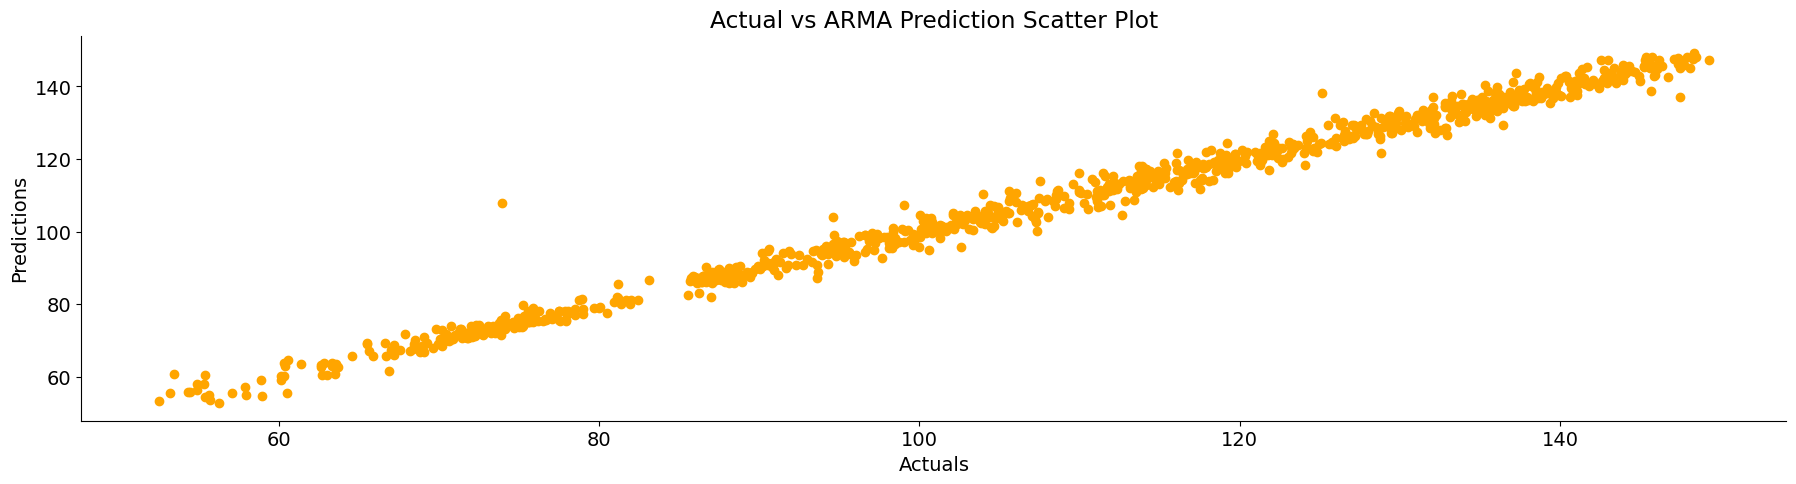

In [56]:
plt.scatter(predictions['Actual'], predictions['Predictions'], color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actual vs ARMA Prediction Scatter Plot')
plt.savefig('arima.jpg')
plt.show()


In [57]:
ARMA_mse = mean_squared_error(predictions['Actual'], predictions['Predictions'])
print(f"The Mean Squared error of the ARMA model is {round(ARMA_mse,4)}.")


The Mean Squared error of the ARMA model is 5.8261.


Fit an ARIMA model¶
Okay so now that we have built a successful ARMA model, let's move towards finding out what's ARIMA? ARMA and ARIMA are essentially the same with only 1 major difference that's is I which stands for integrated which means that the data is stationary. Stationary data refers to time-series data that’s been made 'stationary' by subtracting the observations from the previous values.

The parameter d is known as the degree of differencing. it indicates the number of times the lagged indicators have been subtracted to make the data stationary.

Therefore, ARIMA models may be defined as:

ARIMA(1, 0, 0) – known as the first-order autoregressive model

ARIMA(0, 1, 0) – known as the random walk model

ARIMA(1, 1, 0) – known as the differenced first-order autoregressive model, and so on.

Once the parameters (p, d, q) have been defined, the ARIMA model aims to estimate the coefficients α and θ, which is the result of using previous data points to forecast values.



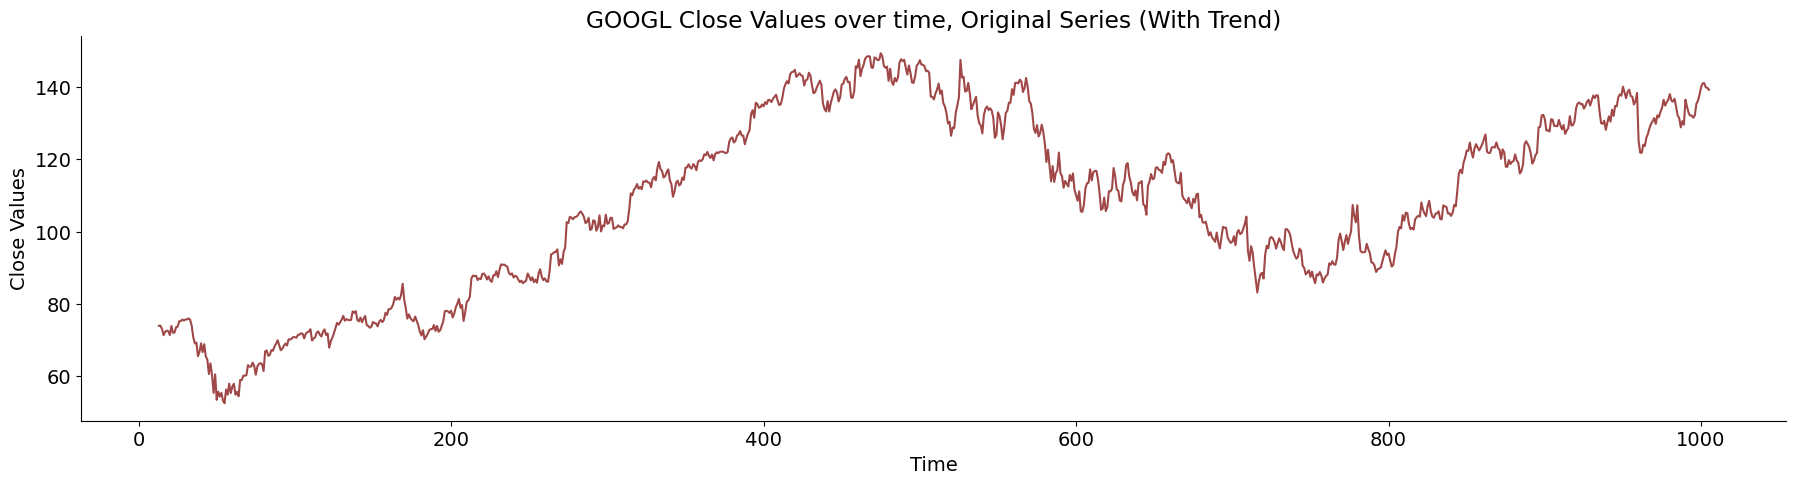

In [58]:
df['Close'].plot(color='#A04747')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Time')
plt.ylabel('Close Values')
plt.title(f'{symbol} Close Values over time, Original Series (With Trend)')
plt.show()


We can see there is a trend in the data and we know that ARMA or ARIMA cannot handle trends so we must make it stationary so we can simply do 1 lag of the original series and see if that makes it stationary. Usually we cannot say that 1 or 2 or 3 lags will be enough to make the series stationary.

It's something that has to be figured out through trial and error.



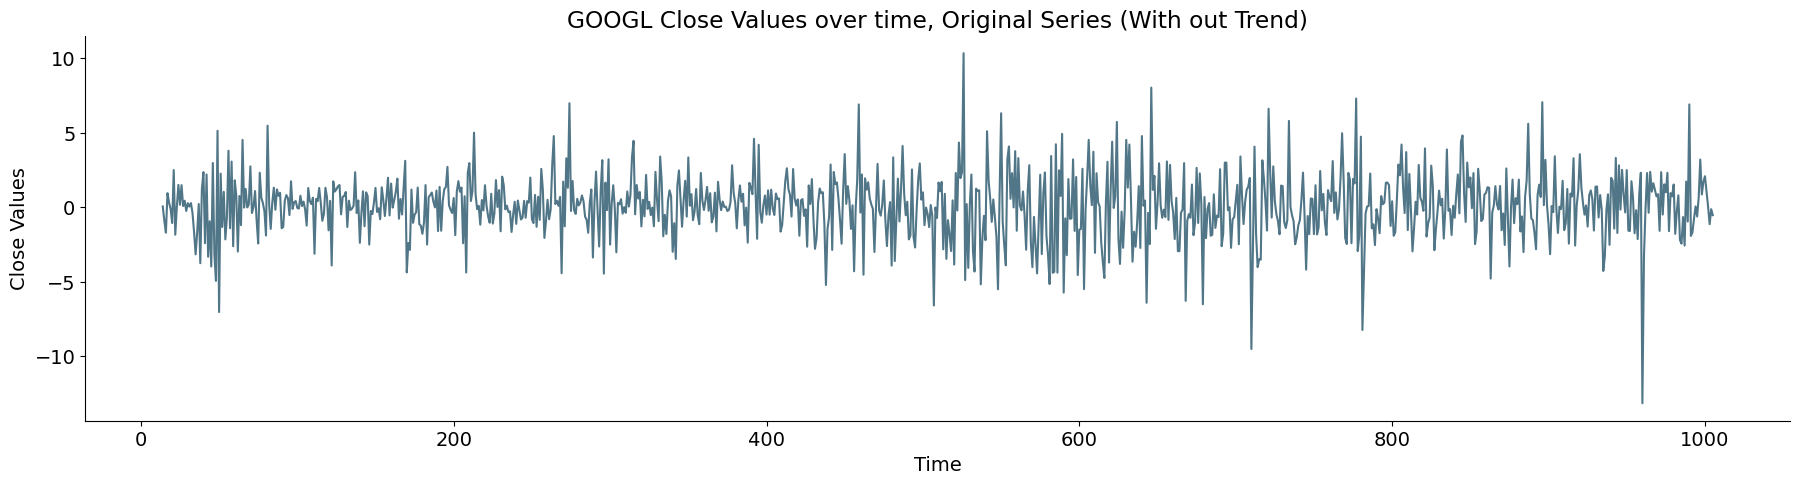

In [59]:
(df['Close'] - df['Close'].shift(1)).plot(color='#507687')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Time')
plt.ylabel('Close Values')
plt.title(f'{symbol} Close Values over time, Original Series (With out Trend)')
plt.show()


It's quite clear now that the series is stationary and we can now train our ARIMA model on this data but wait, what does this mean for the d value we have introduced in the ARIMA model.

Well, d will be 1 since we have differenced the series 1 time to get to the stationary data hence 1. Had it taken 2 or 3 lags, we would have taken that value as d for ARIMA modelling. Let's go ahead and fit the model. It's the same procedure with a small change. The second value in the order argument passed to the model will be 1 to tell the model we want differenced series at 1 lag.



In [60]:
exogenous_features = ['Open', 'High', 'Low']
model = ARIMA(endog=df['Close'], exog=df[exogenous_features], order=(1,1,0))
arima_fitted = model.fit()


c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JalpaZenisha\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [61]:
#Summary of the model
arima_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  993
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1303.310
Date:                Tue, 04 Feb 2025   AIC                           2616.619
Time:                        15:01:11   BIC                           2641.118
Sample:                             0   HQIC                          2625.934
                                - 993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.6690      0.021    -31.325      0.000      -0.711      -0.627
High           0.7548      0.022     34.352      0.000       0.712       0.798
Low            0.8428      0.025     34.358      0.000       0.795       0.891
ar.L1         -0.5164      0.022    -23.334      0.000      -0.560      -0.473
sigma2         0.8101      0.028     28.896      0.000       0.755       0.865
===================================================================================
Ljung-Box (L1) (Q):                  27.42   Jarque-Bera (JB):               110.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Create a df with dates, actual values and the predictions by the ARIMA model
arima_predictions = arima_fitted.predict().to_frame()
arima_predictions['Actual'] = df['Close']
arima_predictions['Date'] = df['Date']
arima_predictions = arima_predictions[['Date', 'Actual', 'predicted_mean']]
arima_predictions.rename(columns={'predicted_mean': 'Predictions'}, inplace=True)
arima_predictions['Probability'] = round(1/(1 + np.exp(-arima_predictions['Predictions']))*100,2)
arima_predictions.head(5)

,Date,Actual,Predictions,Probability
13,2020-01-22,73.925507,69.026665,100.0
14,2020-01-23,73.966362,73.633672,100.0
15,2020-01-24,73.043716,72.925589,100.0
16,2020-01-27,71.327934,71.113188,100.0
17,2020-01-28,72.263046,72.003885,100.0


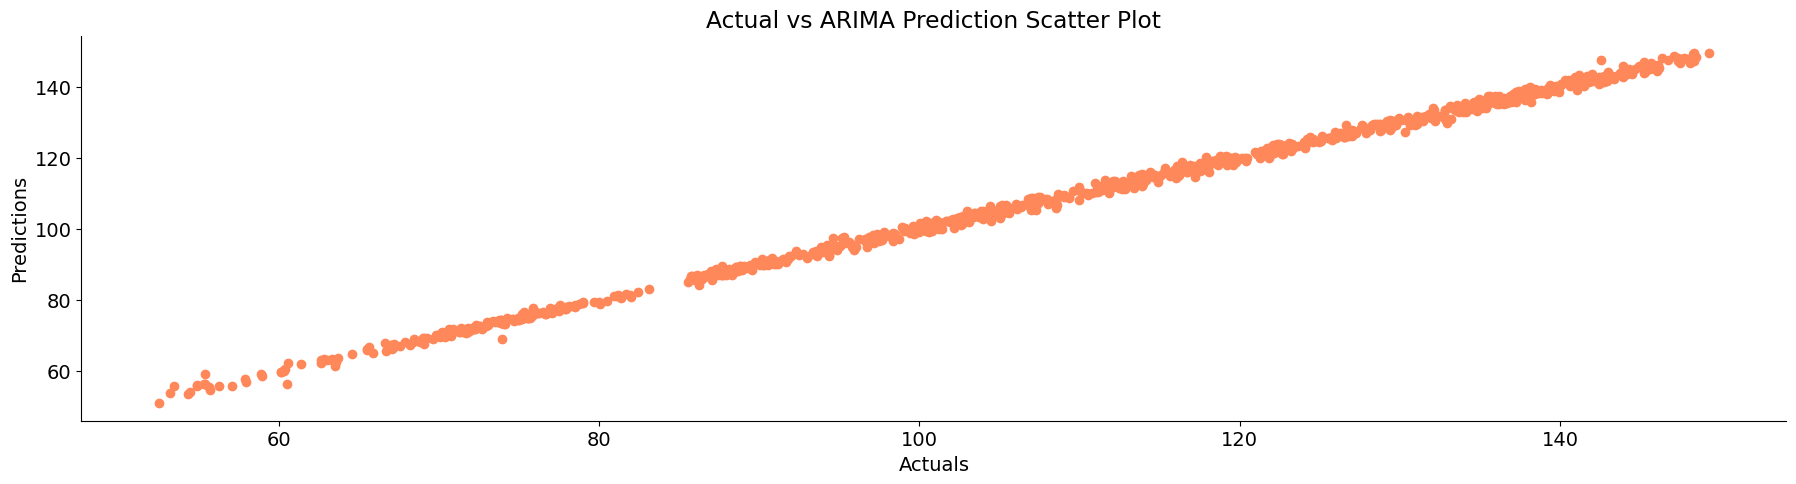

In [64]:
plt.scatter(arima_predictions['Actual'], arima_predictions['Predictions'], color='#FF885B')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actual vs ARIMA Prediction Scatter Plot')
plt.savefig('ARIMA.jpg')
plt.show()


In [65]:
ARIMA_mse = mean_squared_error(arima_predictions['Actual'], arima_predictions['Predictions'])
#Probability or say confidence of the Prediction made by the AR model
probabilites = arima_predictions['Probability'].values
conf = round(np.mean(probabilites),2)
print(f"The model is {conf}% confident in the predictions made by the ARIMA Model")
print(f"The Mean Squared error of the ARMA model is {round(ARIMA_mse,2)}.")


The model is 100.0% confident in the predictions made by the ARIMA Model
The Mean Squared error of the ARMA model is 0.83.


We can clearly see that see that ARIMA model with more predictors and stationary series helped us reach a lower MSE which is favorable for the end result. Now let's take a look at the applications and the Limitations of the ARIMA model.



Applications of the ARIMA Model¶
In business and finance, the ARIMA model can be used to forecast future quantities (or even prices) based on historical data. 
Therefore, for the model to be reliable, the data must be reliable and must show a relatively long time span over which it’s been collected. Some of the applications of the ARIMA model in business are listed below:

- Forecasting the quantity of a good needed for the next time period based on historical data.
- Forecasting sales and interpreting seasonal changes in sales
- Estimating the impact of marketing events, new product launches, and so on.

ARIMA models can be created in data analytics and data science software like R and Python.

Limitations of the ARIMA Model

Although ARIMA models can be highly accurate and reliable under the appropriate conditions and data availability, one of the key limitations of the model is that the parameters (p, d, q) need to be manually defined ; therefore, finding the most accurate fit can be a long trial-and-error process.

Similarly, the model depends highly on the reliability of historical data and the differencing of the data. It is important to ensure that data was collected accurately and over a long period of time so that the model provides accurate results and forecasts.

Conclusion

We have explored the ARIMA model and its application in time series forecasting. We started with an introduction to time series data and discussed the importance of preprocessing in building accurate models.

We then delved into the specifics of ARIMA modeling, covering the selection of parameters, model training, and forecasting.

Through practical examples, we demonstrated how to implement ARIMA models in Python, highlighting the importance of evaluating model performance using appropriate metrics. We also discussed the real-world applications of ARIMA models, such as in forecasting sales, inventory management, and assessing the impact of marketing events.

While ARIMA is a powerful tool, it is crucial to acknowledge its limitations, including the need for reliable historical data and the manual selection of model parameters. Despite these challenges, ARIMA remains a valuable method for time series analysis and forecasting.